# Miller age

In [1]:
ood_seed = 9

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "dataset_complete_Miller.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

adata.obs["age"] = adata.obs["age"].astype("str").astype("category")
adata.obs["age_int"] = adata.obs["age"].astype(str).astype(float).astype(int).astype(str).astype("category")

adata.obs["age_continuous"] = adata.obs["age"].astype(float)
df = adata.obs.groupby(["cell_type", "age"]).size()
df2 = adata.obs.groupby(["cell_type"]).size()
availables = [(i, df[i]) for i in df.index if df[i] > 100 and df2[i[0]] > 350]

In [7]:
df

cell_type                            age 
Bud tip adjacent cells               11.5    169
                                     15.0    282
                                     18.0    777
                                     21.0      0
Bud tip progenitor                   11.5    273
                                     15.0    338
                                     18.0    683
                                     21.0      2
Deuterosomal cells                   11.5      2
                                     15.0    145
                                     18.0    111
                                     21.0     49
Hub cells                            11.5    218
                                     15.0    308
                                     18.0    620
                                     21.0      2
Intermediate trachea ciliated cells  11.5      0
                                     15.0     59
                                     18.0      0
                           

In [8]:
availables, len(availables)

([(('Bud tip adjacent cells', '11.5'), 169),
  (('Bud tip adjacent cells', '15.0'), 282),
  (('Bud tip adjacent cells', '18.0'), 777),
  (('Bud tip progenitor', '11.5'), 273),
  (('Bud tip progenitor', '15.0'), 338),
  (('Bud tip progenitor', '18.0'), 683),
  (('Hub cells', '11.5'), 218),
  (('Hub cells', '15.0'), 308),
  (('Hub cells', '18.0'), 620),
  (('Lung ciliated cells', '15.0'), 692),
  (('Lung ciliated cells', '18.0'), 494),
  (('Lung ciliated cells', '21.0'), 165),
  (('Lung secretory cells', '15.0'), 595),
  (('Lung secretory cells', '21.0'), 438),
  (('Submucosal gland cells', '15.0'), 380),
  (('Submucosal gland cells', '18.0'), 156)],
 16)

In [9]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask


def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["cell_type"] == choice[0][0]) & (adata.obs["age"] == choice[0][1]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

(('Lung ciliated cells', '15.0'), 692)


Removed datapoint: 692

train         5324
validation    1389
ood            692
Name: split, dtype: int64

In [10]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [11]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="age_int",
    control_group="11",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['integration_donor'],
)

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 98105.17it/s]

  0%|          | 0/7405 [00:00<?, ?it/s]

100%|██████████| 7405/7405 [00:00<00:00, 1000928.81it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [12]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [13]:
model.train(max_epochs=400)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 198.44it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:03<20:23,  3.07s/it]

Epoch 1/400:   0%|          | 1/400 [00:03<20:23,  3.07s/it, v_num=1, recon=1.1e+3, r2_mean=0.0545, adv_loss=3.46, acc_pert=0.328, acc_integration_donor=0.111]

Epoch 2/400:   0%|          | 1/400 [00:03<20:23,  3.07s/it, v_num=1, recon=1.1e+3, r2_mean=0.0545, adv_loss=3.46, acc_pert=0.328, acc_integration_donor=0.111]

Epoch 2/400:   0%|          | 2/400 [00:05<17:46,  2.68s/it, v_num=1, recon=1.1e+3, r2_mean=0.0545, adv_loss=3.46, acc_pert=0.328, acc_integration_donor=0.111]

Epoch 2/400:   0%|          | 2/400 [00:05<17:46,  2.68s/it, v_num=1, recon=941, r2_mean=0.284, adv_loss=3.06, acc_pert=0.435, acc_integration_donor=0.291]    

Epoch 3/400:   0%|          | 2/400 [00:05<17:46,  2.68s/it, v_num=1, recon=941, r2_mean=0.284, adv_loss=3.06, acc_pert=0.435, acc_integration_donor=0.291]

Epoch 3/400:   1%|          | 3/400 [00:07<16:45,  2.53s/it, v_num=1, recon=941, r2_mean=0.284, adv_loss=3.06, acc_pert=0.435, acc_integration_donor=0.291]

Epoch 3/400:   1%|          | 3/400 [00:07<16:45,  2.53s/it, v_num=1, recon=874, r2_mean=0.39, adv_loss=2.72, acc_pert=0.508, acc_integration_donor=0.445] 

Epoch 4/400:   1%|          | 3/400 [00:07<16:45,  2.53s/it, v_num=1, recon=874, r2_mean=0.39, adv_loss=2.72, acc_pert=0.508, acc_integration_donor=0.445]

Epoch 4/400:   1%|          | 4/400 [00:10<16:19,  2.47s/it, v_num=1, recon=874, r2_mean=0.39, adv_loss=2.72, acc_pert=0.508, acc_integration_donor=0.445]

Epoch 4/400:   1%|          | 4/400 [00:10<16:19,  2.47s/it, v_num=1, recon=841, r2_mean=0.425, adv_loss=2.46, acc_pert=0.536, acc_integration_donor=0.506]

Epoch 5/400:   1%|          | 4/400 [00:10<16:19,  2.47s/it, v_num=1, recon=841, r2_mean=0.425, adv_loss=2.46, acc_pert=0.536, acc_integration_donor=0.506]

Epoch 5/400:   1%|▏         | 5/400 [00:12<16:04,  2.44s/it, v_num=1, recon=841, r2_mean=0.425, adv_loss=2.46, acc_pert=0.536, acc_integration_donor=0.506]

Epoch 5/400:   1%|▏         | 5/400 [00:12<16:04,  2.44s/it, v_num=1, recon=821, r2_mean=0.445, adv_loss=2.32, acc_pert=0.543, acc_integration_donor=0.52] 

Epoch 6/400:   1%|▏         | 5/400 [00:12<16:04,  2.44s/it, v_num=1, recon=821, r2_mean=0.445, adv_loss=2.32, acc_pert=0.543, acc_integration_donor=0.52]

Epoch 6/400:   2%|▏         | 6/400 [00:14<15:50,  2.41s/it, v_num=1, recon=821, r2_mean=0.445, adv_loss=2.32, acc_pert=0.543, acc_integration_donor=0.52]

Epoch 6/400:   2%|▏         | 6/400 [00:14<15:50,  2.41s/it, v_num=1, recon=808, r2_mean=0.463, adv_loss=2.28, acc_pert=0.55, acc_integration_donor=0.526]

Epoch 7/400:   2%|▏         | 6/400 [00:14<15:50,  2.41s/it, v_num=1, recon=808, r2_mean=0.463, adv_loss=2.28, acc_pert=0.55, acc_integration_donor=0.526]

Epoch 7/400:   2%|▏         | 7/400 [00:17<15:51,  2.42s/it, v_num=1, recon=808, r2_mean=0.463, adv_loss=2.28, acc_pert=0.55, acc_integration_donor=0.526]

Epoch 7/400:   2%|▏         | 7/400 [00:17<15:51,  2.42s/it, v_num=1, recon=798, r2_mean=0.459, adv_loss=2.27, acc_pert=0.546, acc_integration_donor=0.53]

Epoch 8/400:   2%|▏         | 7/400 [00:17<15:51,  2.42s/it, v_num=1, recon=798, r2_mean=0.459, adv_loss=2.27, acc_pert=0.546, acc_integration_donor=0.53]

Epoch 8/400:   2%|▏         | 8/400 [00:19<15:48,  2.42s/it, v_num=1, recon=798, r2_mean=0.459, adv_loss=2.27, acc_pert=0.546, acc_integration_donor=0.53]

Epoch 8/400:   2%|▏         | 8/400 [00:19<15:48,  2.42s/it, v_num=1, recon=792, r2_mean=0.464, adv_loss=2.25, acc_pert=0.553, acc_integration_donor=0.534]

Epoch 9/400:   2%|▏         | 8/400 [00:19<15:48,  2.42s/it, v_num=1, recon=792, r2_mean=0.464, adv_loss=2.25, acc_pert=0.553, acc_integration_donor=0.534]

Epoch 9/400:   2%|▏         | 9/400 [00:22<16:18,  2.50s/it, v_num=1, recon=792, r2_mean=0.464, adv_loss=2.25, acc_pert=0.553, acc_integration_donor=0.534]

Epoch 9/400:   2%|▏         | 9/400 [00:22<16:18,  2.50s/it, v_num=1, recon=786, r2_mean=0.473, adv_loss=2.19, acc_pert=0.566, acc_integration_donor=0.544]

Epoch 10/400:   2%|▏         | 9/400 [00:22<16:18,  2.50s/it, v_num=1, recon=786, r2_mean=0.473, adv_loss=2.19, acc_pert=0.566, acc_integration_donor=0.544]


disnt_basal = 0.5474345375720511

disnt_after = 1.0121579442124942

val_r2_mean = 0.4961797750808976

val_r2_var = 0.15842227163639935


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [00:32<31:55,  4.91s/it, v_num=1, recon=786, r2_mean=0.473, adv_loss=2.19, acc_pert=0.566, acc_integration_donor=0.544]

Epoch 10/400:   2%|▎         | 10/400 [00:32<31:55,  4.91s/it, v_num=1, recon=780, r2_mean=0.479, adv_loss=2.19, acc_pert=0.562, acc_integration_donor=0.534, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [00:32<31:55,  4.91s/it, v_num=1, recon=780, r2_mean=0.479, adv_loss=2.19, acc_pert=0.562, acc_integration_donor=0.534, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:35<26:54,  4.15s/it, v_num=1, recon=780, r2_mean=0.479, adv_loss=2.19, acc_pert=0.562, acc_integration_donor=0.534, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [00:35<26:54,  4.15s/it, v_num=1, recon=776, r2_mean=0.484, adv_loss=2.21, acc_pert=0.557, acc_integration_donor=0.525, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [00:35<26:54,  4.15s/it, v_num=1, recon=776, r2_mean=0.484, adv_loss=2.21, acc_pert=0.557, acc_integration_donor=0.525, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:38<24:47,  3.83s/it, v_num=1, recon=776, r2_mean=0.484, adv_loss=2.21, acc_pert=0.557, acc_integration_donor=0.525, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [00:38<24:47,  3.83s/it, v_num=1, recon=772, r2_mean=0.492, adv_loss=2.2, acc_pert=0.547, acc_integration_donor=0.515, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan] 

Epoch 13/400:   3%|▎         | 12/400 [00:38<24:47,  3.83s/it, v_num=1, recon=772, r2_mean=0.492, adv_loss=2.2, acc_pert=0.547, acc_integration_donor=0.515, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:40<21:59,  3.41s/it, v_num=1, recon=772, r2_mean=0.492, adv_loss=2.2, acc_pert=0.547, acc_integration_donor=0.515, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [00:40<21:59,  3.41s/it, v_num=1, recon=769, r2_mean=0.493, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.526, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 14/400:   3%|▎         | 13/400 [00:40<21:59,  3.41s/it, v_num=1, recon=769, r2_mean=0.493, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.526, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:43<19:53,  3.09s/it, v_num=1, recon=769, r2_mean=0.493, adv_loss=2.17, acc_pert=0.554, acc_integration_donor=0.526, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [00:43<19:53,  3.09s/it, v_num=1, recon=764, r2_mean=0.501, adv_loss=2.16, acc_pert=0.561, acc_integration_donor=0.519, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [00:43<19:53,  3.09s/it, v_num=1, recon=764, r2_mean=0.501, adv_loss=2.16, acc_pert=0.561, acc_integration_donor=0.519, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:45<18:29,  2.88s/it, v_num=1, recon=764, r2_mean=0.501, adv_loss=2.16, acc_pert=0.561, acc_integration_donor=0.519, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [00:45<18:29,  2.88s/it, v_num=1, recon=763, r2_mean=0.5, adv_loss=2.17, acc_pert=0.56, acc_integration_donor=0.512, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]   

Epoch 16/400:   4%|▍         | 15/400 [00:45<18:29,  2.88s/it, v_num=1, recon=763, r2_mean=0.5, adv_loss=2.17, acc_pert=0.56, acc_integration_donor=0.512, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:47<17:26,  2.73s/it, v_num=1, recon=763, r2_mean=0.5, adv_loss=2.17, acc_pert=0.56, acc_integration_donor=0.512, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [00:47<17:26,  2.73s/it, v_num=1, recon=759, r2_mean=0.509, adv_loss=2.14, acc_pert=0.561, acc_integration_donor=0.518, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [00:47<17:26,  2.73s/it, v_num=1, recon=759, r2_mean=0.509, adv_loss=2.14, acc_pert=0.561, acc_integration_donor=0.518, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:50<16:41,  2.61s/it, v_num=1, recon=759, r2_mean=0.509, adv_loss=2.14, acc_pert=0.561, acc_integration_donor=0.518, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [00:50<16:41,  2.61s/it, v_num=1, recon=758, r2_mean=0.512, adv_loss=2.14, acc_pert=0.563, acc_integration_donor=0.514, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [00:50<16:41,  2.61s/it, v_num=1, recon=758, r2_mean=0.512, adv_loss=2.14, acc_pert=0.563, acc_integration_donor=0.514, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:52<16:10,  2.54s/it, v_num=1, recon=758, r2_mean=0.512, adv_loss=2.14, acc_pert=0.563, acc_integration_donor=0.514, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [00:52<16:10,  2.54s/it, v_num=1, recon=754, r2_mean=0.52, adv_loss=2.15, acc_pert=0.563, acc_integration_donor=0.515, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan] 

Epoch 19/400:   4%|▍         | 18/400 [00:52<16:10,  2.54s/it, v_num=1, recon=754, r2_mean=0.52, adv_loss=2.15, acc_pert=0.563, acc_integration_donor=0.515, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:55<15:52,  2.50s/it, v_num=1, recon=754, r2_mean=0.52, adv_loss=2.15, acc_pert=0.563, acc_integration_donor=0.515, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [00:55<15:52,  2.50s/it, v_num=1, recon=753, r2_mean=0.516, adv_loss=2.13, acc_pert=0.566, acc_integration_donor=0.517, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [00:55<15:52,  2.50s/it, v_num=1, recon=753, r2_mean=0.516, adv_loss=2.13, acc_pert=0.566, acc_integration_donor=0.517, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]


disnt_basal = 0.5445146638998216

disnt_after = 0.9795893359813085

val_r2_mean = 0.49904240667819977

val_r2_var = 0.297344833612442


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [01:06<33:37,  5.31s/it, v_num=1, recon=753, r2_mean=0.516, adv_loss=2.13, acc_pert=0.566, acc_integration_donor=0.517, val_recon=808, disnt_basal=0.547, disnt_after=1.01, val_r2_mean=0.496, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [01:06<33:37,  5.31s/it, v_num=1, recon=749, r2_mean=0.526, adv_loss=2.14, acc_pert=0.563, acc_integration_donor=0.512, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [01:06<33:37,  5.31s/it, v_num=1, recon=749, r2_mean=0.526, adv_loss=2.14, acc_pert=0.563, acc_integration_donor=0.512, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:10<30:30,  4.83s/it, v_num=1, recon=749, r2_mean=0.526, adv_loss=2.14, acc_pert=0.563, acc_integration_donor=0.512, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [01:10<30:30,  4.83s/it, v_num=1, recon=747, r2_mean=0.527, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.512, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [01:10<30:30,  4.83s/it, v_num=1, recon=747, r2_mean=0.527, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.512, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:13<25:58,  4.12s/it, v_num=1, recon=747, r2_mean=0.527, adv_loss=2.16, acc_pert=0.55, acc_integration_donor=0.512, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [01:13<25:58,  4.12s/it, v_num=1, recon=746, r2_mean=0.526, adv_loss=2.18, acc_pert=0.552, acc_integration_donor=0.497, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [01:13<25:58,  4.12s/it, v_num=1, recon=746, r2_mean=0.526, adv_loss=2.18, acc_pert=0.552, acc_integration_donor=0.497, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:15<22:45,  3.62s/it, v_num=1, recon=746, r2_mean=0.526, adv_loss=2.18, acc_pert=0.552, acc_integration_donor=0.497, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [01:15<22:45,  3.62s/it, v_num=1, recon=745, r2_mean=0.531, adv_loss=2.17, acc_pert=0.549, acc_integration_donor=0.504, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [01:15<22:45,  3.62s/it, v_num=1, recon=745, r2_mean=0.531, adv_loss=2.17, acc_pert=0.549, acc_integration_donor=0.504, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:17<20:24,  3.26s/it, v_num=1, recon=745, r2_mean=0.531, adv_loss=2.17, acc_pert=0.549, acc_integration_donor=0.504, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [01:17<20:24,  3.26s/it, v_num=1, recon=743, r2_mean=0.535, adv_loss=2.18, acc_pert=0.548, acc_integration_donor=0.498, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [01:17<20:24,  3.26s/it, v_num=1, recon=743, r2_mean=0.535, adv_loss=2.18, acc_pert=0.548, acc_integration_donor=0.498, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:20<19:04,  3.05s/it, v_num=1, recon=743, r2_mean=0.535, adv_loss=2.18, acc_pert=0.548, acc_integration_donor=0.498, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [01:20<19:04,  3.05s/it, v_num=1, recon=740, r2_mean=0.535, adv_loss=2.21, acc_pert=0.543, acc_integration_donor=0.494, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [01:20<19:04,  3.05s/it, v_num=1, recon=740, r2_mean=0.535, adv_loss=2.21, acc_pert=0.543, acc_integration_donor=0.494, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:23<18:13,  2.92s/it, v_num=1, recon=740, r2_mean=0.535, adv_loss=2.21, acc_pert=0.543, acc_integration_donor=0.494, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [01:23<18:13,  2.92s/it, v_num=1, recon=740, r2_mean=0.539, adv_loss=2.19, acc_pert=0.547, acc_integration_donor=0.497, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [01:23<18:13,  2.92s/it, v_num=1, recon=740, r2_mean=0.539, adv_loss=2.19, acc_pert=0.547, acc_integration_donor=0.497, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:25<17:09,  2.76s/it, v_num=1, recon=740, r2_mean=0.539, adv_loss=2.19, acc_pert=0.547, acc_integration_donor=0.497, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [01:25<17:09,  2.76s/it, v_num=1, recon=739, r2_mean=0.544, adv_loss=2.19, acc_pert=0.542, acc_integration_donor=0.502, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [01:25<17:09,  2.76s/it, v_num=1, recon=739, r2_mean=0.544, adv_loss=2.19, acc_pert=0.542, acc_integration_donor=0.502, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:27<16:26,  2.65s/it, v_num=1, recon=739, r2_mean=0.544, adv_loss=2.19, acc_pert=0.542, acc_integration_donor=0.502, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [01:27<16:26,  2.65s/it, v_num=1, recon=738, r2_mean=0.55, adv_loss=2.2, acc_pert=0.549, acc_integration_donor=0.496, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]  

Epoch 29/400:   7%|▋         | 28/400 [01:27<16:26,  2.65s/it, v_num=1, recon=738, r2_mean=0.55, adv_loss=2.2, acc_pert=0.549, acc_integration_donor=0.496, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:31<17:55,  2.90s/it, v_num=1, recon=738, r2_mean=0.55, adv_loss=2.2, acc_pert=0.549, acc_integration_donor=0.496, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [01:31<17:55,  2.90s/it, v_num=1, recon=735, r2_mean=0.543, adv_loss=2.2, acc_pert=0.549, acc_integration_donor=0.497, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [01:31<17:55,  2.90s/it, v_num=1, recon=735, r2_mean=0.543, adv_loss=2.2, acc_pert=0.549, acc_integration_donor=0.497, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]


disnt_basal = 0.5249538062007146

disnt_after = 0.9806445854915989

val_r2_mean = 0.5046486603942785

val_r2_var = 0.35112101110545074


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [01:45<39:22,  6.39s/it, v_num=1, recon=735, r2_mean=0.543, adv_loss=2.2, acc_pert=0.549, acc_integration_donor=0.497, val_recon=776, disnt_basal=0.545, disnt_after=0.98, val_r2_mean=0.499, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [01:45<39:22,  6.39s/it, v_num=1, recon=734, r2_mean=0.545, adv_loss=2.19, acc_pert=0.542, acc_integration_donor=0.498, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [01:45<39:22,  6.39s/it, v_num=1, recon=734, r2_mean=0.545, adv_loss=2.19, acc_pert=0.542, acc_integration_donor=0.498, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:48<31:52,  5.18s/it, v_num=1, recon=734, r2_mean=0.545, adv_loss=2.19, acc_pert=0.542, acc_integration_donor=0.498, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [01:48<31:52,  5.18s/it, v_num=1, recon=733, r2_mean=0.543, adv_loss=2.18, acc_pert=0.539, acc_integration_donor=0.508, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [01:48<31:52,  5.18s/it, v_num=1, recon=733, r2_mean=0.543, adv_loss=2.18, acc_pert=0.539, acc_integration_donor=0.508, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:50<27:15,  4.45s/it, v_num=1, recon=733, r2_mean=0.543, adv_loss=2.18, acc_pert=0.539, acc_integration_donor=0.508, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [01:50<27:15,  4.45s/it, v_num=1, recon=732, r2_mean=0.547, adv_loss=2.21, acc_pert=0.545, acc_integration_donor=0.49, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan] 

Epoch 33/400:   8%|▊         | 32/400 [01:50<27:15,  4.45s/it, v_num=1, recon=732, r2_mean=0.547, adv_loss=2.21, acc_pert=0.545, acc_integration_donor=0.49, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:53<23:27,  3.83s/it, v_num=1, recon=732, r2_mean=0.547, adv_loss=2.21, acc_pert=0.545, acc_integration_donor=0.49, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [01:53<23:27,  3.83s/it, v_num=1, recon=731, r2_mean=0.551, adv_loss=2.2, acc_pert=0.537, acc_integration_donor=0.5, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]  

Epoch 34/400:   8%|▊         | 33/400 [01:53<23:27,  3.83s/it, v_num=1, recon=731, r2_mean=0.551, adv_loss=2.2, acc_pert=0.537, acc_integration_donor=0.5, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:55<20:46,  3.40s/it, v_num=1, recon=731, r2_mean=0.551, adv_loss=2.2, acc_pert=0.537, acc_integration_donor=0.5, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [01:55<20:46,  3.40s/it, v_num=1, recon=729, r2_mean=0.551, adv_loss=2.21, acc_pert=0.535, acc_integration_donor=0.5, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [01:55<20:46,  3.40s/it, v_num=1, recon=729, r2_mean=0.551, adv_loss=2.21, acc_pert=0.535, acc_integration_donor=0.5, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:58<18:50,  3.10s/it, v_num=1, recon=729, r2_mean=0.551, adv_loss=2.21, acc_pert=0.535, acc_integration_donor=0.5, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [01:58<18:50,  3.10s/it, v_num=1, recon=729, r2_mean=0.553, adv_loss=2.22, acc_pert=0.536, acc_integration_donor=0.499, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [01:58<18:50,  3.10s/it, v_num=1, recon=729, r2_mean=0.553, adv_loss=2.22, acc_pert=0.536, acc_integration_donor=0.499, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:00<17:22,  2.86s/it, v_num=1, recon=729, r2_mean=0.553, adv_loss=2.22, acc_pert=0.536, acc_integration_donor=0.499, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [02:00<17:22,  2.86s/it, v_num=1, recon=728, r2_mean=0.552, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.498, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan] 

Epoch 37/400:   9%|▉         | 36/400 [02:00<17:22,  2.86s/it, v_num=1, recon=728, r2_mean=0.552, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.498, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:02<16:29,  2.73s/it, v_num=1, recon=728, r2_mean=0.552, adv_loss=2.2, acc_pert=0.535, acc_integration_donor=0.498, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [02:02<16:29,  2.73s/it, v_num=1, recon=726, r2_mean=0.548, adv_loss=2.22, acc_pert=0.538, acc_integration_donor=0.495, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [02:02<16:29,  2.73s/it, v_num=1, recon=726, r2_mean=0.548, adv_loss=2.22, acc_pert=0.538, acc_integration_donor=0.495, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:05<15:45,  2.61s/it, v_num=1, recon=726, r2_mean=0.548, adv_loss=2.22, acc_pert=0.538, acc_integration_donor=0.495, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [02:05<15:45,  2.61s/it, v_num=1, recon=725, r2_mean=0.552, adv_loss=2.19, acc_pert=0.538, acc_integration_donor=0.505, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [02:05<15:45,  2.61s/it, v_num=1, recon=725, r2_mean=0.552, adv_loss=2.19, acc_pert=0.538, acc_integration_donor=0.505, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:07<15:15,  2.54s/it, v_num=1, recon=725, r2_mean=0.552, adv_loss=2.19, acc_pert=0.538, acc_integration_donor=0.505, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [02:07<15:15,  2.54s/it, v_num=1, recon=724, r2_mean=0.555, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.503, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [02:07<15:15,  2.54s/it, v_num=1, recon=724, r2_mean=0.555, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.503, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]


disnt_basal = 0.5131012095545662

disnt_after = 0.989431150265366

val_r2_mean = 0.5084848607128317

val_r2_var = 0.35840047760443255


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [02:14<23:42,  3.95s/it, v_num=1, recon=724, r2_mean=0.555, adv_loss=2.21, acc_pert=0.533, acc_integration_donor=0.503, val_recon=768, disnt_basal=0.525, disnt_after=0.981, val_r2_mean=0.505, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [02:14<23:42,  3.95s/it, v_num=1, recon=723, r2_mean=0.557, adv_loss=2.22, acc_pert=0.525, acc_integration_donor=0.501, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [02:14<23:42,  3.95s/it, v_num=1, recon=723, r2_mean=0.557, adv_loss=2.22, acc_pert=0.525, acc_integration_donor=0.501, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:17<20:41,  3.46s/it, v_num=1, recon=723, r2_mean=0.557, adv_loss=2.22, acc_pert=0.525, acc_integration_donor=0.501, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [02:17<20:41,  3.46s/it, v_num=1, recon=722, r2_mean=0.56, adv_loss=2.23, acc_pert=0.531, acc_integration_donor=0.5, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]   

Epoch 42/400:  10%|█         | 41/400 [02:17<20:41,  3.46s/it, v_num=1, recon=722, r2_mean=0.56, adv_loss=2.23, acc_pert=0.531, acc_integration_donor=0.5, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:19<18:41,  3.13s/it, v_num=1, recon=722, r2_mean=0.56, adv_loss=2.23, acc_pert=0.531, acc_integration_donor=0.5, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [02:19<18:41,  3.13s/it, v_num=1, recon=721, r2_mean=0.557, adv_loss=2.21, acc_pert=0.529, acc_integration_donor=0.508, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [02:19<18:41,  3.13s/it, v_num=1, recon=721, r2_mean=0.557, adv_loss=2.21, acc_pert=0.529, acc_integration_donor=0.508, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:22<17:58,  3.02s/it, v_num=1, recon=721, r2_mean=0.557, adv_loss=2.21, acc_pert=0.529, acc_integration_donor=0.508, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [02:22<17:58,  3.02s/it, v_num=1, recon=721, r2_mean=0.562, adv_loss=2.23, acc_pert=0.526, acc_integration_donor=0.496, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [02:22<17:58,  3.02s/it, v_num=1, recon=721, r2_mean=0.562, adv_loss=2.23, acc_pert=0.526, acc_integration_donor=0.496, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:24<16:40,  2.81s/it, v_num=1, recon=721, r2_mean=0.562, adv_loss=2.23, acc_pert=0.526, acc_integration_donor=0.496, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [02:24<16:40,  2.81s/it, v_num=1, recon=720, r2_mean=0.558, adv_loss=2.23, acc_pert=0.521, acc_integration_donor=0.498, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [02:24<16:40,  2.81s/it, v_num=1, recon=720, r2_mean=0.558, adv_loss=2.23, acc_pert=0.521, acc_integration_donor=0.498, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:27<15:54,  2.69s/it, v_num=1, recon=720, r2_mean=0.558, adv_loss=2.23, acc_pert=0.521, acc_integration_donor=0.498, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [02:27<15:54,  2.69s/it, v_num=1, recon=718, r2_mean=0.561, adv_loss=2.25, acc_pert=0.522, acc_integration_donor=0.493, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 46/400:  11%|█▏        | 45/400 [02:27<15:54,  2.69s/it, v_num=1, recon=718, r2_mean=0.561, adv_loss=2.25, acc_pert=0.522, acc_integration_donor=0.493, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:29<15:18,  2.60s/it, v_num=1, recon=718, r2_mean=0.561, adv_loss=2.25, acc_pert=0.522, acc_integration_donor=0.493, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [02:29<15:18,  2.60s/it, v_num=1, recon=717, r2_mean=0.56, adv_loss=2.24, acc_pert=0.514, acc_integration_donor=0.495, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan] 

Epoch 47/400:  12%|█▏        | 46/400 [02:29<15:18,  2.60s/it, v_num=1, recon=717, r2_mean=0.56, adv_loss=2.24, acc_pert=0.514, acc_integration_donor=0.495, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:31<14:55,  2.54s/it, v_num=1, recon=717, r2_mean=0.56, adv_loss=2.24, acc_pert=0.514, acc_integration_donor=0.495, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [02:31<14:55,  2.54s/it, v_num=1, recon=717, r2_mean=0.562, adv_loss=2.25, acc_pert=0.517, acc_integration_donor=0.498, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [02:31<14:55,  2.54s/it, v_num=1, recon=717, r2_mean=0.562, adv_loss=2.25, acc_pert=0.517, acc_integration_donor=0.498, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:34<14:34,  2.48s/it, v_num=1, recon=717, r2_mean=0.562, adv_loss=2.25, acc_pert=0.517, acc_integration_donor=0.498, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [02:34<14:34,  2.48s/it, v_num=1, recon=715, r2_mean=0.568, adv_loss=2.27, acc_pert=0.525, acc_integration_donor=0.502, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [02:34<14:34,  2.48s/it, v_num=1, recon=715, r2_mean=0.568, adv_loss=2.27, acc_pert=0.525, acc_integration_donor=0.502, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:36<14:22,  2.46s/it, v_num=1, recon=715, r2_mean=0.568, adv_loss=2.27, acc_pert=0.525, acc_integration_donor=0.502, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [02:36<14:22,  2.46s/it, v_num=1, recon=715, r2_mean=0.565, adv_loss=2.28, acc_pert=0.514, acc_integration_donor=0.498, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [02:36<14:22,  2.46s/it, v_num=1, recon=715, r2_mean=0.565, adv_loss=2.28, acc_pert=0.514, acc_integration_donor=0.498, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]


disnt_basal = 0.4994422047954139

disnt_after = 0.9970225346219705

val_r2_mean = 0.5056152181191877

val_r2_var = 0.3677136694843119


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [02:44<24:20,  4.17s/it, v_num=1, recon=715, r2_mean=0.565, adv_loss=2.28, acc_pert=0.514, acc_integration_donor=0.498, val_recon=765, disnt_basal=0.513, disnt_after=0.989, val_r2_mean=0.508, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [02:44<24:20,  4.17s/it, v_num=1, recon=714, r2_mean=0.566, adv_loss=2.25, acc_pert=0.517, acc_integration_donor=0.501, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [02:44<24:20,  4.17s/it, v_num=1, recon=714, r2_mean=0.566, adv_loss=2.25, acc_pert=0.517, acc_integration_donor=0.501, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:47<22:31,  3.87s/it, v_num=1, recon=714, r2_mean=0.566, adv_loss=2.25, acc_pert=0.517, acc_integration_donor=0.501, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [02:47<22:31,  3.87s/it, v_num=1, recon=713, r2_mean=0.563, adv_loss=2.26, acc_pert=0.52, acc_integration_donor=0.496, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan] 

Epoch 52/400:  13%|█▎        | 51/400 [02:47<22:31,  3.87s/it, v_num=1, recon=713, r2_mean=0.563, adv_loss=2.26, acc_pert=0.52, acc_integration_donor=0.496, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:50<19:58,  3.45s/it, v_num=1, recon=713, r2_mean=0.563, adv_loss=2.26, acc_pert=0.52, acc_integration_donor=0.496, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [02:50<19:58,  3.45s/it, v_num=1, recon=713, r2_mean=0.567, adv_loss=2.25, acc_pert=0.521, acc_integration_donor=0.498, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [02:50<19:58,  3.45s/it, v_num=1, recon=713, r2_mean=0.567, adv_loss=2.25, acc_pert=0.521, acc_integration_donor=0.498, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:52<18:02,  3.12s/it, v_num=1, recon=713, r2_mean=0.567, adv_loss=2.25, acc_pert=0.521, acc_integration_donor=0.498, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [02:52<18:02,  3.12s/it, v_num=1, recon=711, r2_mean=0.566, adv_loss=2.27, acc_pert=0.507, acc_integration_donor=0.496, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [02:52<18:02,  3.12s/it, v_num=1, recon=711, r2_mean=0.566, adv_loss=2.27, acc_pert=0.507, acc_integration_donor=0.496, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:55<16:37,  2.88s/it, v_num=1, recon=711, r2_mean=0.566, adv_loss=2.27, acc_pert=0.507, acc_integration_donor=0.496, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [02:55<16:37,  2.88s/it, v_num=1, recon=710, r2_mean=0.568, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.494, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 55/400:  14%|█▎        | 54/400 [02:55<16:37,  2.88s/it, v_num=1, recon=710, r2_mean=0.568, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.494, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:57<15:48,  2.75s/it, v_num=1, recon=710, r2_mean=0.568, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.494, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [02:57<15:48,  2.75s/it, v_num=1, recon=709, r2_mean=0.572, adv_loss=2.27, acc_pert=0.503, acc_integration_donor=0.499, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [02:57<15:48,  2.75s/it, v_num=1, recon=709, r2_mean=0.572, adv_loss=2.27, acc_pert=0.503, acc_integration_donor=0.499, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:59<15:05,  2.63s/it, v_num=1, recon=709, r2_mean=0.572, adv_loss=2.27, acc_pert=0.503, acc_integration_donor=0.499, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [02:59<15:05,  2.63s/it, v_num=1, recon=708, r2_mean=0.576, adv_loss=2.28, acc_pert=0.505, acc_integration_donor=0.497, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [02:59<15:05,  2.63s/it, v_num=1, recon=708, r2_mean=0.576, adv_loss=2.28, acc_pert=0.505, acc_integration_donor=0.497, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:02<14:30,  2.54s/it, v_num=1, recon=708, r2_mean=0.576, adv_loss=2.28, acc_pert=0.505, acc_integration_donor=0.497, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [03:02<14:30,  2.54s/it, v_num=1, recon=708, r2_mean=0.572, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.497, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [03:02<14:30,  2.54s/it, v_num=1, recon=708, r2_mean=0.572, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.497, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:04<14:09,  2.48s/it, v_num=1, recon=708, r2_mean=0.572, adv_loss=2.28, acc_pert=0.513, acc_integration_donor=0.497, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [03:04<14:09,  2.48s/it, v_num=1, recon=706, r2_mean=0.571, adv_loss=2.28, acc_pert=0.517, acc_integration_donor=0.492, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [03:04<14:09,  2.48s/it, v_num=1, recon=706, r2_mean=0.571, adv_loss=2.28, acc_pert=0.517, acc_integration_donor=0.492, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:06<13:55,  2.45s/it, v_num=1, recon=706, r2_mean=0.571, adv_loss=2.28, acc_pert=0.517, acc_integration_donor=0.492, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [03:06<13:55,  2.45s/it, v_num=1, recon=706, r2_mean=0.573, adv_loss=2.3, acc_pert=0.502, acc_integration_donor=0.492, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan] 

Epoch 60/400:  15%|█▍        | 59/400 [03:06<13:55,  2.45s/it, v_num=1, recon=706, r2_mean=0.573, adv_loss=2.3, acc_pert=0.502, acc_integration_donor=0.492, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]


disnt_basal = 0.49562236542980903

disnt_after = 0.9831751125936308

val_r2_mean = 0.5045809054916556

val_r2_var = 0.3828909424218265

Epoch 60/400:  15%|█▌        | 60/400 [03:18<28:55,  5.10s/it, v_num=1, recon=706, r2_mean=0.573, adv_loss=2.3, acc_pert=0.502, acc_integration_donor=0.492, val_recon=762, disnt_basal=0.499, disnt_after=0.997, val_r2_mean=0.506, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [03:18<28:55,  5.10s/it, v_num=1, recon=705, r2_mean=0.576, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.49, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan] 

Epoch 61/400:  15%|█▌        | 60/400 [03:18<28:55,  5.10s/it, v_num=1, recon=705, r2_mean=0.576, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.49, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:25<31:53,  5.64s/it, v_num=1, recon=705, r2_mean=0.576, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.49, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [03:25<31:53,  5.64s/it, v_num=1, recon=704, r2_mean=0.573, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.493, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [03:25<31:53,  5.64s/it, v_num=1, recon=704, r2_mean=0.573, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.493, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:27<26:17,  4.67s/it, v_num=1, recon=704, r2_mean=0.573, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.493, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [03:27<26:17,  4.67s/it, v_num=1, recon=703, r2_mean=0.577, adv_loss=2.28, acc_pert=0.515, acc_integration_donor=0.491, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [03:27<26:17,  4.67s/it, v_num=1, recon=703, r2_mean=0.577, adv_loss=2.28, acc_pert=0.515, acc_integration_donor=0.491, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:29<22:15,  3.96s/it, v_num=1, recon=703, r2_mean=0.577, adv_loss=2.28, acc_pert=0.515, acc_integration_donor=0.491, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [03:29<22:15,  3.96s/it, v_num=1, recon=702, r2_mean=0.575, adv_loss=2.31, acc_pert=0.5, acc_integration_donor=0.503, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]  

Epoch 64/400:  16%|█▌        | 63/400 [03:29<22:15,  3.96s/it, v_num=1, recon=702, r2_mean=0.575, adv_loss=2.31, acc_pert=0.5, acc_integration_donor=0.503, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:32<19:30,  3.48s/it, v_num=1, recon=702, r2_mean=0.575, adv_loss=2.31, acc_pert=0.5, acc_integration_donor=0.503, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [03:32<19:30,  3.48s/it, v_num=1, recon=702, r2_mean=0.573, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.503, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [03:32<19:30,  3.48s/it, v_num=1, recon=702, r2_mean=0.573, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.503, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:34<17:42,  3.17s/it, v_num=1, recon=702, r2_mean=0.573, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.503, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [03:34<17:42,  3.17s/it, v_num=1, recon=702, r2_mean=0.576, adv_loss=2.31, acc_pert=0.512, acc_integration_donor=0.497, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [03:34<17:42,  3.17s/it, v_num=1, recon=702, r2_mean=0.576, adv_loss=2.31, acc_pert=0.512, acc_integration_donor=0.497, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:36<16:19,  2.93s/it, v_num=1, recon=702, r2_mean=0.576, adv_loss=2.31, acc_pert=0.512, acc_integration_donor=0.497, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [03:36<16:19,  2.93s/it, v_num=1, recon=698, r2_mean=0.582, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.506, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan] 

Epoch 67/400:  16%|█▋        | 66/400 [03:36<16:19,  2.93s/it, v_num=1, recon=698, r2_mean=0.582, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.506, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:39<15:18,  2.76s/it, v_num=1, recon=698, r2_mean=0.582, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.506, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [03:39<15:18,  2.76s/it, v_num=1, recon=699, r2_mean=0.579, adv_loss=2.32, acc_pert=0.497, acc_integration_donor=0.494, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [03:39<15:18,  2.76s/it, v_num=1, recon=699, r2_mean=0.579, adv_loss=2.32, acc_pert=0.497, acc_integration_donor=0.494, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:41<14:39,  2.65s/it, v_num=1, recon=699, r2_mean=0.579, adv_loss=2.32, acc_pert=0.497, acc_integration_donor=0.494, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [03:41<14:39,  2.65s/it, v_num=1, recon=698, r2_mean=0.58, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.494, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan] 

Epoch 69/400:  17%|█▋        | 68/400 [03:41<14:39,  2.65s/it, v_num=1, recon=698, r2_mean=0.58, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.494, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:44<14:10,  2.57s/it, v_num=1, recon=698, r2_mean=0.58, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.494, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [03:44<14:10,  2.57s/it, v_num=1, recon=698, r2_mean=0.582, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.494, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [03:44<14:10,  2.57s/it, v_num=1, recon=698, r2_mean=0.582, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.494, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]


disnt_basal = 0.48630273091615533

disnt_after = 1.0010932660322445

val_r2_mean = 0.5063987861980092

val_r2_var = 0.3959888131781058


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [03:57<32:38,  5.93s/it, v_num=1, recon=698, r2_mean=0.582, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.494, val_recon=763, disnt_basal=0.496, disnt_after=0.983, val_r2_mean=0.505, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [03:57<32:38,  5.93s/it, v_num=1, recon=696, r2_mean=0.583, adv_loss=2.32, acc_pert=0.496, acc_integration_donor=0.494, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]    

Epoch 71/400:  18%|█▊        | 70/400 [03:57<32:38,  5.93s/it, v_num=1, recon=696, r2_mean=0.583, adv_loss=2.32, acc_pert=0.496, acc_integration_donor=0.494, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:00<27:07,  4.95s/it, v_num=1, recon=696, r2_mean=0.583, adv_loss=2.32, acc_pert=0.496, acc_integration_donor=0.494, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [04:00<27:07,  4.95s/it, v_num=1, recon=696, r2_mean=0.584, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.493, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [04:00<27:07,  4.95s/it, v_num=1, recon=696, r2_mean=0.584, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.493, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:02<22:57,  4.20s/it, v_num=1, recon=696, r2_mean=0.584, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.493, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [04:02<22:57,  4.20s/it, v_num=1, recon=695, r2_mean=0.582, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.499, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [04:02<22:57,  4.20s/it, v_num=1, recon=695, r2_mean=0.582, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.499, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:05<19:59,  3.67s/it, v_num=1, recon=695, r2_mean=0.582, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.499, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [04:05<19:59,  3.67s/it, v_num=1, recon=694, r2_mean=0.583, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.487, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [04:05<19:59,  3.67s/it, v_num=1, recon=694, r2_mean=0.583, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.487, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:07<17:52,  3.29s/it, v_num=1, recon=694, r2_mean=0.583, adv_loss=2.33, acc_pert=0.497, acc_integration_donor=0.487, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [04:07<17:52,  3.29s/it, v_num=1, recon=693, r2_mean=0.586, adv_loss=2.31, acc_pert=0.504, acc_integration_donor=0.5, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]  

Epoch 75/400:  18%|█▊        | 74/400 [04:07<17:52,  3.29s/it, v_num=1, recon=693, r2_mean=0.586, adv_loss=2.31, acc_pert=0.504, acc_integration_donor=0.5, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:10<16:20,  3.02s/it, v_num=1, recon=693, r2_mean=0.586, adv_loss=2.31, acc_pert=0.504, acc_integration_donor=0.5, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [04:10<16:20,  3.02s/it, v_num=1, recon=694, r2_mean=0.583, adv_loss=2.32, acc_pert=0.498, acc_integration_donor=0.499, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [04:10<16:20,  3.02s/it, v_num=1, recon=694, r2_mean=0.583, adv_loss=2.32, acc_pert=0.498, acc_integration_donor=0.499, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:12<15:21,  2.85s/it, v_num=1, recon=694, r2_mean=0.583, adv_loss=2.32, acc_pert=0.498, acc_integration_donor=0.499, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [04:12<15:21,  2.85s/it, v_num=1, recon=691, r2_mean=0.584, adv_loss=2.31, acc_pert=0.506, acc_integration_donor=0.5, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]  

Epoch 77/400:  19%|█▉        | 76/400 [04:12<15:21,  2.85s/it, v_num=1, recon=691, r2_mean=0.584, adv_loss=2.31, acc_pert=0.506, acc_integration_donor=0.5, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:15<14:40,  2.73s/it, v_num=1, recon=691, r2_mean=0.584, adv_loss=2.31, acc_pert=0.506, acc_integration_donor=0.5, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [04:15<14:40,  2.73s/it, v_num=1, recon=690, r2_mean=0.587, adv_loss=2.31, acc_pert=0.507, acc_integration_donor=0.501, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [04:15<14:40,  2.73s/it, v_num=1, recon=690, r2_mean=0.587, adv_loss=2.31, acc_pert=0.507, acc_integration_donor=0.501, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:17<14:09,  2.64s/it, v_num=1, recon=690, r2_mean=0.587, adv_loss=2.31, acc_pert=0.507, acc_integration_donor=0.501, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [04:17<14:09,  2.64s/it, v_num=1, recon=689, r2_mean=0.588, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.498, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [04:17<14:09,  2.64s/it, v_num=1, recon=689, r2_mean=0.588, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.498, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:20<14:26,  2.70s/it, v_num=1, recon=689, r2_mean=0.588, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.498, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [04:20<14:26,  2.70s/it, v_num=1, recon=690, r2_mean=0.583, adv_loss=2.34, acc_pert=0.487, acc_integration_donor=0.492, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [04:20<14:26,  2.70s/it, v_num=1, recon=690, r2_mean=0.583, adv_loss=2.34, acc_pert=0.487, acc_integration_donor=0.492, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]


disnt_basal = 0.48310296328649593

disnt_after = 0.9890830266928407

val_r2_mean = 0.5089976665648547

val_r2_var = 0.38748679716478696

Epoch 80/400:  20%|██        | 80/400 [04:32<29:01,  5.44s/it, v_num=1, recon=690, r2_mean=0.583, adv_loss=2.34, acc_pert=0.487, acc_integration_donor=0.492, val_recon=764, disnt_basal=0.486, disnt_after=1, val_r2_mean=0.506, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [04:32<29:01,  5.44s/it, v_num=1, recon=689, r2_mean=0.587, adv_loss=2.34, acc_pert=0.493, acc_integration_donor=0.504, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [04:32<29:01,  5.44s/it, v_num=1, recon=689, r2_mean=0.587, adv_loss=2.34, acc_pert=0.493, acc_integration_donor=0.504, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:34<24:15,  4.56s/it, v_num=1, recon=689, r2_mean=0.587, adv_loss=2.34, acc_pert=0.493, acc_integration_donor=0.504, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [04:34<24:15,  4.56s/it, v_num=1, recon=688, r2_mean=0.586, adv_loss=2.32, acc_pert=0.498, acc_integration_donor=0.499, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [04:34<24:15,  4.56s/it, v_num=1, recon=688, r2_mean=0.586, adv_loss=2.32, acc_pert=0.498, acc_integration_donor=0.499, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:37<20:53,  3.94s/it, v_num=1, recon=688, r2_mean=0.586, adv_loss=2.32, acc_pert=0.498, acc_integration_donor=0.499, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [04:37<20:53,  3.94s/it, v_num=1, recon=687, r2_mean=0.588, adv_loss=2.32, acc_pert=0.498, acc_integration_donor=0.494, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [04:37<20:53,  3.94s/it, v_num=1, recon=687, r2_mean=0.588, adv_loss=2.32, acc_pert=0.498, acc_integration_donor=0.494, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:39<18:28,  3.50s/it, v_num=1, recon=687, r2_mean=0.588, adv_loss=2.32, acc_pert=0.498, acc_integration_donor=0.494, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [04:39<18:28,  3.50s/it, v_num=1, recon=686, r2_mean=0.583, adv_loss=2.33, acc_pert=0.5, acc_integration_donor=0.494, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]  

Epoch 84/400:  21%|██        | 83/400 [04:39<18:28,  3.50s/it, v_num=1, recon=686, r2_mean=0.583, adv_loss=2.33, acc_pert=0.5, acc_integration_donor=0.494, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:42<16:43,  3.18s/it, v_num=1, recon=686, r2_mean=0.583, adv_loss=2.33, acc_pert=0.5, acc_integration_donor=0.494, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [04:42<16:43,  3.18s/it, v_num=1, recon=686, r2_mean=0.589, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.498, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [04:42<16:43,  3.18s/it, v_num=1, recon=686, r2_mean=0.589, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.498, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:44<15:27,  2.95s/it, v_num=1, recon=686, r2_mean=0.589, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.498, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [04:44<15:27,  2.95s/it, v_num=1, recon=684, r2_mean=0.593, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.496, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [04:44<15:27,  2.95s/it, v_num=1, recon=684, r2_mean=0.593, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.496, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:46<14:36,  2.79s/it, v_num=1, recon=684, r2_mean=0.593, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.496, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [04:46<14:36,  2.79s/it, v_num=1, recon=683, r2_mean=0.588, adv_loss=2.32, acc_pert=0.497, acc_integration_donor=0.495, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [04:46<14:36,  2.79s/it, v_num=1, recon=683, r2_mean=0.588, adv_loss=2.32, acc_pert=0.497, acc_integration_donor=0.495, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:49<13:53,  2.66s/it, v_num=1, recon=683, r2_mean=0.588, adv_loss=2.32, acc_pert=0.497, acc_integration_donor=0.495, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [04:49<13:53,  2.66s/it, v_num=1, recon=682, r2_mean=0.588, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.497, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [04:49<13:53,  2.66s/it, v_num=1, recon=682, r2_mean=0.588, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.497, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:51<13:28,  2.59s/it, v_num=1, recon=682, r2_mean=0.588, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.497, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [04:51<13:28,  2.59s/it, v_num=1, recon=682, r2_mean=0.596, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.489, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [04:51<13:28,  2.59s/it, v_num=1, recon=682, r2_mean=0.596, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.489, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [04:54<13:15,  2.56s/it, v_num=1, recon=682, r2_mean=0.596, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.489, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [04:54<13:15,  2.56s/it, v_num=1, recon=682, r2_mean=0.595, adv_loss=2.31, acc_pert=0.506, acc_integration_donor=0.503, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [04:54<13:15,  2.56s/it, v_num=1, recon=682, r2_mean=0.595, adv_loss=2.31, acc_pert=0.506, acc_integration_donor=0.503, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]


disnt_basal = 0.4793749406960352

disnt_after = 1.005817720607839

val_r2_mean = 0.5086002759151644

val_r2_var = 0.395456154238094


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [05:09<32:30,  6.29s/it, v_num=1, recon=682, r2_mean=0.595, adv_loss=2.31, acc_pert=0.506, acc_integration_donor=0.503, val_recon=764, disnt_basal=0.483, disnt_after=0.989, val_r2_mean=0.509, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [05:09<32:30,  6.29s/it, v_num=1, recon=680, r2_mean=0.592, adv_loss=2.33, acc_pert=0.496, acc_integration_donor=0.497, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan] 

Epoch 91/400:  22%|██▎       | 90/400 [05:09<32:30,  6.29s/it, v_num=1, recon=680, r2_mean=0.592, adv_loss=2.33, acc_pert=0.496, acc_integration_donor=0.497, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:11<26:38,  5.17s/it, v_num=1, recon=680, r2_mean=0.592, adv_loss=2.33, acc_pert=0.496, acc_integration_donor=0.497, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [05:11<26:38,  5.17s/it, v_num=1, recon=679, r2_mean=0.596, adv_loss=2.35, acc_pert=0.484, acc_integration_donor=0.495, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [05:11<26:38,  5.17s/it, v_num=1, recon=679, r2_mean=0.596, adv_loss=2.35, acc_pert=0.484, acc_integration_donor=0.495, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:14<22:19,  4.35s/it, v_num=1, recon=679, r2_mean=0.596, adv_loss=2.35, acc_pert=0.484, acc_integration_donor=0.495, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [05:14<22:19,  4.35s/it, v_num=1, recon=678, r2_mean=0.594, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.497, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [05:14<22:19,  4.35s/it, v_num=1, recon=678, r2_mean=0.594, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.497, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:16<19:18,  3.77s/it, v_num=1, recon=678, r2_mean=0.594, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.497, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [05:16<19:18,  3.77s/it, v_num=1, recon=678, r2_mean=0.597, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.498, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan] 

Epoch 94/400:  23%|██▎       | 93/400 [05:16<19:18,  3.77s/it, v_num=1, recon=678, r2_mean=0.597, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.498, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:19<17:06,  3.35s/it, v_num=1, recon=678, r2_mean=0.597, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.498, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [05:19<17:06,  3.35s/it, v_num=1, recon=676, r2_mean=0.596, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.494, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [05:19<17:06,  3.35s/it, v_num=1, recon=676, r2_mean=0.596, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.494, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:21<15:42,  3.09s/it, v_num=1, recon=676, r2_mean=0.596, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.494, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [05:21<15:42,  3.09s/it, v_num=1, recon=676, r2_mean=0.595, adv_loss=2.34, acc_pert=0.488, acc_integration_donor=0.493, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [05:21<15:42,  3.09s/it, v_num=1, recon=676, r2_mean=0.595, adv_loss=2.34, acc_pert=0.488, acc_integration_donor=0.493, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:24<15:37,  3.08s/it, v_num=1, recon=676, r2_mean=0.595, adv_loss=2.34, acc_pert=0.488, acc_integration_donor=0.493, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [05:24<15:37,  3.08s/it, v_num=1, recon=675, r2_mean=0.596, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.491, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [05:24<15:37,  3.08s/it, v_num=1, recon=675, r2_mean=0.596, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.491, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:27<14:41,  2.91s/it, v_num=1, recon=675, r2_mean=0.596, adv_loss=2.36, acc_pert=0.488, acc_integration_donor=0.491, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [05:27<14:41,  2.91s/it, v_num=1, recon=675, r2_mean=0.601, adv_loss=2.38, acc_pert=0.478, acc_integration_donor=0.495, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [05:27<14:41,  2.91s/it, v_num=1, recon=675, r2_mean=0.601, adv_loss=2.38, acc_pert=0.478, acc_integration_donor=0.495, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:29<13:52,  2.76s/it, v_num=1, recon=675, r2_mean=0.601, adv_loss=2.38, acc_pert=0.478, acc_integration_donor=0.495, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [05:29<13:52,  2.76s/it, v_num=1, recon=675, r2_mean=0.598, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.492, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [05:29<13:52,  2.76s/it, v_num=1, recon=675, r2_mean=0.598, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.492, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:31<13:27,  2.68s/it, v_num=1, recon=675, r2_mean=0.598, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.492, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [05:31<13:27,  2.68s/it, v_num=1, recon=673, r2_mean=0.598, adv_loss=2.36, acc_pert=0.49, acc_integration_donor=0.488, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan] 

Epoch 100/400:  25%|██▍       | 99/400 [05:31<13:27,  2.68s/it, v_num=1, recon=673, r2_mean=0.598, adv_loss=2.36, acc_pert=0.49, acc_integration_donor=0.488, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]


disnt_basal = 0.4772688761420053

disnt_after = 0.9929040570173473

val_r2_mean = 0.4990813664414666

val_r2_var = 0.3940929811109196

Epoch 100/400:  25%|██▌       | 100/400 [05:42<24:28,  4.89s/it, v_num=1, recon=673, r2_mean=0.598, adv_loss=2.36, acc_pert=0.49, acc_integration_donor=0.488, val_recon=766, disnt_basal=0.479, disnt_after=1.01, val_r2_mean=0.509, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [05:42<24:28,  4.89s/it, v_num=1, recon=671, r2_mean=0.603, adv_loss=2.35, acc_pert=0.483, acc_integration_donor=0.496, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [05:42<24:28,  4.89s/it, v_num=1, recon=671, r2_mean=0.603, adv_loss=2.35, acc_pert=0.483, acc_integration_donor=0.496, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:44<20:45,  4.17s/it, v_num=1, recon=671, r2_mean=0.603, adv_loss=2.35, acc_pert=0.483, acc_integration_donor=0.496, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [05:44<20:45,  4.17s/it, v_num=1, recon=672, r2_mean=0.599, adv_loss=2.34, acc_pert=0.49, acc_integration_donor=0.497, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan] 

Epoch 102/400:  25%|██▌       | 101/400 [05:44<20:45,  4.17s/it, v_num=1, recon=672, r2_mean=0.599, adv_loss=2.34, acc_pert=0.49, acc_integration_donor=0.497, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [05:47<18:42,  3.77s/it, v_num=1, recon=672, r2_mean=0.599, adv_loss=2.34, acc_pert=0.49, acc_integration_donor=0.497, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [05:47<18:42,  3.77s/it, v_num=1, recon=670, r2_mean=0.601, adv_loss=2.37, acc_pert=0.489, acc_integration_donor=0.493, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [05:47<18:42,  3.77s/it, v_num=1, recon=670, r2_mean=0.601, adv_loss=2.37, acc_pert=0.489, acc_integration_donor=0.493, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [05:49<16:38,  3.36s/it, v_num=1, recon=670, r2_mean=0.601, adv_loss=2.37, acc_pert=0.489, acc_integration_donor=0.493, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [05:49<16:38,  3.36s/it, v_num=1, recon=669, r2_mean=0.601, adv_loss=2.34, acc_pert=0.49, acc_integration_donor=0.497, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan] 

Epoch 104/400:  26%|██▌       | 103/400 [05:49<16:38,  3.36s/it, v_num=1, recon=669, r2_mean=0.601, adv_loss=2.34, acc_pert=0.49, acc_integration_donor=0.497, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [05:52<15:15,  3.09s/it, v_num=1, recon=669, r2_mean=0.601, adv_loss=2.34, acc_pert=0.49, acc_integration_donor=0.497, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [05:52<15:15,  3.09s/it, v_num=1, recon=669, r2_mean=0.601, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.492, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [05:52<15:15,  3.09s/it, v_num=1, recon=669, r2_mean=0.601, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.492, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [05:54<14:19,  2.91s/it, v_num=1, recon=669, r2_mean=0.601, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.492, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [05:54<14:19,  2.91s/it, v_num=1, recon=668, r2_mean=0.599, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.492, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]  

Epoch 106/400:  26%|██▋       | 105/400 [05:54<14:19,  2.91s/it, v_num=1, recon=668, r2_mean=0.599, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.492, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [05:57<13:27,  2.75s/it, v_num=1, recon=668, r2_mean=0.599, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.492, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [05:57<13:27,  2.75s/it, v_num=1, recon=669, r2_mean=0.599, adv_loss=2.35, acc_pert=0.487, acc_integration_donor=0.494, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [05:57<13:27,  2.75s/it, v_num=1, recon=669, r2_mean=0.599, adv_loss=2.35, acc_pert=0.487, acc_integration_donor=0.494, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [05:59<12:47,  2.62s/it, v_num=1, recon=669, r2_mean=0.599, adv_loss=2.35, acc_pert=0.487, acc_integration_donor=0.494, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [05:59<12:47,  2.62s/it, v_num=1, recon=667, r2_mean=0.6, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.49, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]   

Epoch 108/400:  27%|██▋       | 107/400 [05:59<12:47,  2.62s/it, v_num=1, recon=667, r2_mean=0.6, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.49, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:01<12:22,  2.54s/it, v_num=1, recon=667, r2_mean=0.6, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.49, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [06:01<12:22,  2.54s/it, v_num=1, recon=665, r2_mean=0.603, adv_loss=2.36, acc_pert=0.489, acc_integration_donor=0.491, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [06:01<12:22,  2.54s/it, v_num=1, recon=665, r2_mean=0.603, adv_loss=2.36, acc_pert=0.489, acc_integration_donor=0.491, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:04<11:58,  2.47s/it, v_num=1, recon=665, r2_mean=0.603, adv_loss=2.36, acc_pert=0.489, acc_integration_donor=0.491, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [06:04<11:58,  2.47s/it, v_num=1, recon=666, r2_mean=0.601, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.496, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [06:04<11:58,  2.47s/it, v_num=1, recon=666, r2_mean=0.601, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.496, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]


disnt_basal = 0.4662501560501133

disnt_after = 0.9825912072984849

val_r2_mean = 0.5016134435480292

val_r2_var = 0.38795147429813037

Epoch 110/400:  28%|██▊       | 110/400 [06:21<34:02,  7.04s/it, v_num=1, recon=666, r2_mean=0.601, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.496, val_recon=768, disnt_basal=0.477, disnt_after=0.993, val_r2_mean=0.499, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [06:21<34:02,  7.04s/it, v_num=1, recon=665, r2_mean=0.603, adv_loss=2.36, acc_pert=0.484, acc_integration_donor=0.497, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [06:21<34:02,  7.04s/it, v_num=1, recon=665, r2_mean=0.603, adv_loss=2.36, acc_pert=0.484, acc_integration_donor=0.497, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:24<27:25,  5.69s/it, v_num=1, recon=665, r2_mean=0.603, adv_loss=2.36, acc_pert=0.484, acc_integration_donor=0.497, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [06:24<27:25,  5.69s/it, v_num=1, recon=664, r2_mean=0.604, adv_loss=2.38, acc_pert=0.478, acc_integration_donor=0.496, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [06:24<27:25,  5.69s/it, v_num=1, recon=664, r2_mean=0.604, adv_loss=2.38, acc_pert=0.478, acc_integration_donor=0.496, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:26<22:52,  4.77s/it, v_num=1, recon=664, r2_mean=0.604, adv_loss=2.38, acc_pert=0.478, acc_integration_donor=0.496, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [06:26<22:52,  4.77s/it, v_num=1, recon=663, r2_mean=0.601, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.499, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [06:26<22:52,  4.77s/it, v_num=1, recon=663, r2_mean=0.601, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.499, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:29<20:04,  4.20s/it, v_num=1, recon=663, r2_mean=0.601, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.499, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [06:29<20:04,  4.20s/it, v_num=1, recon=662, r2_mean=0.606, adv_loss=2.35, acc_pert=0.488, acc_integration_donor=0.5, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]  

Epoch 114/400:  28%|██▊       | 113/400 [06:29<20:04,  4.20s/it, v_num=1, recon=662, r2_mean=0.606, adv_loss=2.35, acc_pert=0.488, acc_integration_donor=0.5, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:32<17:52,  3.75s/it, v_num=1, recon=662, r2_mean=0.606, adv_loss=2.35, acc_pert=0.488, acc_integration_donor=0.5, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [06:32<17:52,  3.75s/it, v_num=1, recon=661, r2_mean=0.607, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.494, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [06:32<17:52,  3.75s/it, v_num=1, recon=661, r2_mean=0.607, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.494, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:35<16:06,  3.39s/it, v_num=1, recon=661, r2_mean=0.607, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.494, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [06:35<16:06,  3.39s/it, v_num=1, recon=661, r2_mean=0.604, adv_loss=2.35, acc_pert=0.494, acc_integration_donor=0.495, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [06:35<16:06,  3.39s/it, v_num=1, recon=661, r2_mean=0.604, adv_loss=2.35, acc_pert=0.494, acc_integration_donor=0.495, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:42<21:20,  4.51s/it, v_num=1, recon=661, r2_mean=0.604, adv_loss=2.35, acc_pert=0.494, acc_integration_donor=0.495, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [06:42<21:20,  4.51s/it, v_num=1, recon=660, r2_mean=0.604, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.498, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [06:42<21:20,  4.51s/it, v_num=1, recon=660, r2_mean=0.604, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.498, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:44<18:28,  3.92s/it, v_num=1, recon=660, r2_mean=0.604, adv_loss=2.35, acc_pert=0.491, acc_integration_donor=0.498, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [06:44<18:28,  3.92s/it, v_num=1, recon=660, r2_mean=0.605, adv_loss=2.36, acc_pert=0.49, acc_integration_donor=0.49, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]  

Epoch 118/400:  29%|██▉       | 117/400 [06:44<18:28,  3.92s/it, v_num=1, recon=660, r2_mean=0.605, adv_loss=2.36, acc_pert=0.49, acc_integration_donor=0.49, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:47<16:36,  3.53s/it, v_num=1, recon=660, r2_mean=0.605, adv_loss=2.36, acc_pert=0.49, acc_integration_donor=0.49, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [06:47<16:36,  3.53s/it, v_num=1, recon=659, r2_mean=0.609, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.494, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [06:47<16:36,  3.53s/it, v_num=1, recon=659, r2_mean=0.609, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.494, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:49<15:15,  3.26s/it, v_num=1, recon=659, r2_mean=0.609, adv_loss=2.35, acc_pert=0.495, acc_integration_donor=0.494, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [06:49<15:15,  3.26s/it, v_num=1, recon=658, r2_mean=0.606, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.497, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [06:49<15:15,  3.26s/it, v_num=1, recon=658, r2_mean=0.606, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.497, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]


disnt_basal = 0.46661409517680963

disnt_after = 0.9890837353627517

val_r2_mean = 0.4992538744753057

val_r2_var = 0.4027245315638455

Epoch 120/400:  30%|███       | 120/400 [07:05<32:42,  7.01s/it, v_num=1, recon=658, r2_mean=0.606, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.497, val_recon=770, disnt_basal=0.466, disnt_after=0.983, val_r2_mean=0.502, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [07:05<32:42,  7.01s/it, v_num=1, recon=657, r2_mean=0.606, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.504, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [07:05<32:42,  7.01s/it, v_num=1, recon=657, r2_mean=0.606, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.504, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:08<26:17,  5.66s/it, v_num=1, recon=657, r2_mean=0.606, adv_loss=2.35, acc_pert=0.497, acc_integration_donor=0.504, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [07:08<26:17,  5.66s/it, v_num=1, recon=657, r2_mean=0.607, adv_loss=2.37, acc_pert=0.485, acc_integration_donor=0.486, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [07:08<26:17,  5.66s/it, v_num=1, recon=657, r2_mean=0.607, adv_loss=2.37, acc_pert=0.485, acc_integration_donor=0.486, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:10<21:43,  4.69s/it, v_num=1, recon=657, r2_mean=0.607, adv_loss=2.37, acc_pert=0.485, acc_integration_donor=0.486, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [07:10<21:43,  4.69s/it, v_num=1, recon=657, r2_mean=0.609, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.497, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [07:10<21:43,  4.69s/it, v_num=1, recon=657, r2_mean=0.609, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.497, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:13<18:28,  4.00s/it, v_num=1, recon=657, r2_mean=0.609, adv_loss=2.36, acc_pert=0.491, acc_integration_donor=0.497, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [07:13<18:28,  4.00s/it, v_num=1, recon=655, r2_mean=0.611, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.5, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]  

Epoch 124/400:  31%|███       | 123/400 [07:13<18:28,  4.00s/it, v_num=1, recon=655, r2_mean=0.611, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.5, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:15<16:18,  3.54s/it, v_num=1, recon=655, r2_mean=0.611, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.5, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [07:15<16:18,  3.54s/it, v_num=1, recon=655, r2_mean=0.612, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.491, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [07:15<16:18,  3.54s/it, v_num=1, recon=655, r2_mean=0.612, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.491, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:17<14:43,  3.21s/it, v_num=1, recon=655, r2_mean=0.612, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.491, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [07:17<14:43,  3.21s/it, v_num=1, recon=653, r2_mean=0.613, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.499, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [07:17<14:43,  3.21s/it, v_num=1, recon=653, r2_mean=0.613, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.499, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:20<13:33,  2.97s/it, v_num=1, recon=653, r2_mean=0.613, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.499, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [07:20<13:33,  2.97s/it, v_num=1, recon=654, r2_mean=0.607, adv_loss=2.36, acc_pert=0.505, acc_integration_donor=0.501, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [07:20<13:33,  2.97s/it, v_num=1, recon=654, r2_mean=0.607, adv_loss=2.36, acc_pert=0.505, acc_integration_donor=0.501, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:22<12:39,  2.78s/it, v_num=1, recon=654, r2_mean=0.607, adv_loss=2.36, acc_pert=0.505, acc_integration_donor=0.501, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [07:22<12:39,  2.78s/it, v_num=1, recon=652, r2_mean=0.613, adv_loss=2.34, acc_pert=0.499, acc_integration_donor=0.502, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [07:22<12:39,  2.78s/it, v_num=1, recon=652, r2_mean=0.613, adv_loss=2.34, acc_pert=0.499, acc_integration_donor=0.502, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:25<12:02,  2.66s/it, v_num=1, recon=652, r2_mean=0.613, adv_loss=2.34, acc_pert=0.499, acc_integration_donor=0.502, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [07:25<12:02,  2.66s/it, v_num=1, recon=652, r2_mean=0.614, adv_loss=2.36, acc_pert=0.486, acc_integration_donor=0.496, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [07:25<12:02,  2.66s/it, v_num=1, recon=652, r2_mean=0.614, adv_loss=2.36, acc_pert=0.486, acc_integration_donor=0.496, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:27<11:37,  2.57s/it, v_num=1, recon=652, r2_mean=0.614, adv_loss=2.36, acc_pert=0.486, acc_integration_donor=0.496, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [07:27<11:37,  2.57s/it, v_num=1, recon=651, r2_mean=0.614, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.504, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [07:27<11:37,  2.57s/it, v_num=1, recon=651, r2_mean=0.614, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.504, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]


disnt_basal = 0.46353890802799075

disnt_after = 0.9904085570966782

val_r2_mean = 0.4954818317835981

val_r2_var = 0.40861396423795004

Epoch 130/400:  32%|███▎      | 130/400 [07:37<21:03,  4.68s/it, v_num=1, recon=651, r2_mean=0.614, adv_loss=2.35, acc_pert=0.493, acc_integration_donor=0.504, val_recon=772, disnt_basal=0.467, disnt_after=0.989, val_r2_mean=0.499, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [07:37<21:03,  4.68s/it, v_num=1, recon=651, r2_mean=0.615, adv_loss=2.36, acc_pert=0.497, acc_integration_donor=0.497, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan] 

Epoch 131/400:  32%|███▎      | 130/400 [07:37<21:03,  4.68s/it, v_num=1, recon=651, r2_mean=0.615, adv_loss=2.36, acc_pert=0.497, acc_integration_donor=0.497, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:39<18:30,  4.13s/it, v_num=1, recon=651, r2_mean=0.615, adv_loss=2.36, acc_pert=0.497, acc_integration_donor=0.497, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [07:39<18:30,  4.13s/it, v_num=1, recon=650, r2_mean=0.614, adv_loss=2.34, acc_pert=0.499, acc_integration_donor=0.497, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [07:39<18:30,  4.13s/it, v_num=1, recon=650, r2_mean=0.614, adv_loss=2.34, acc_pert=0.499, acc_integration_donor=0.497, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:42<16:06,  3.61s/it, v_num=1, recon=650, r2_mean=0.614, adv_loss=2.34, acc_pert=0.499, acc_integration_donor=0.497, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [07:42<16:06,  3.61s/it, v_num=1, recon=649, r2_mean=0.617, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.495, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]  

Epoch 133/400:  33%|███▎      | 132/400 [07:42<16:06,  3.61s/it, v_num=1, recon=649, r2_mean=0.617, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.495, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:44<14:33,  3.27s/it, v_num=1, recon=649, r2_mean=0.617, adv_loss=2.35, acc_pert=0.5, acc_integration_donor=0.495, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [07:44<14:33,  3.27s/it, v_num=1, recon=649, r2_mean=0.615, adv_loss=2.36, acc_pert=0.498, acc_integration_donor=0.498, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [07:44<14:33,  3.27s/it, v_num=1, recon=649, r2_mean=0.615, adv_loss=2.36, acc_pert=0.498, acc_integration_donor=0.498, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [07:47<13:26,  3.03s/it, v_num=1, recon=649, r2_mean=0.615, adv_loss=2.36, acc_pert=0.498, acc_integration_donor=0.498, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [07:47<13:26,  3.03s/it, v_num=1, recon=648, r2_mean=0.614, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.499, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [07:47<13:26,  3.03s/it, v_num=1, recon=648, r2_mean=0.614, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.499, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:49<12:29,  2.83s/it, v_num=1, recon=648, r2_mean=0.614, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.499, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [07:49<12:29,  2.83s/it, v_num=1, recon=647, r2_mean=0.616, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.505, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [07:49<12:29,  2.83s/it, v_num=1, recon=647, r2_mean=0.616, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.505, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:51<11:50,  2.69s/it, v_num=1, recon=647, r2_mean=0.616, adv_loss=2.34, acc_pert=0.496, acc_integration_donor=0.505, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [07:51<11:50,  2.69s/it, v_num=1, recon=646, r2_mean=0.613, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.505, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [07:51<11:50,  2.69s/it, v_num=1, recon=646, r2_mean=0.613, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.505, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [07:54<11:25,  2.61s/it, v_num=1, recon=646, r2_mean=0.613, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.505, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [07:54<11:25,  2.61s/it, v_num=1, recon=646, r2_mean=0.62, adv_loss=2.34, acc_pert=0.491, acc_integration_donor=0.494, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan] 

Epoch 138/400:  34%|███▍      | 137/400 [07:54<11:25,  2.61s/it, v_num=1, recon=646, r2_mean=0.62, adv_loss=2.34, acc_pert=0.491, acc_integration_donor=0.494, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [07:56<11:03,  2.53s/it, v_num=1, recon=646, r2_mean=0.62, adv_loss=2.34, acc_pert=0.491, acc_integration_donor=0.494, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [07:56<11:03,  2.53s/it, v_num=1, recon=645, r2_mean=0.616, adv_loss=2.34, acc_pert=0.492, acc_integration_donor=0.503, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [07:56<11:03,  2.53s/it, v_num=1, recon=645, r2_mean=0.616, adv_loss=2.34, acc_pert=0.492, acc_integration_donor=0.503, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [07:59<10:45,  2.47s/it, v_num=1, recon=645, r2_mean=0.616, adv_loss=2.34, acc_pert=0.492, acc_integration_donor=0.503, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [07:59<10:45,  2.47s/it, v_num=1, recon=644, r2_mean=0.616, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.505, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [07:59<10:45,  2.47s/it, v_num=1, recon=644, r2_mean=0.616, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.505, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]


disnt_basal = 0.4607024749783669

disnt_after = 0.9875238553421795

val_r2_mean = 0.49272596497427334

val_r2_var = 0.3919673954898661

Epoch 140/400:  35%|███▌      | 140/400 [08:08<20:14,  4.67s/it, v_num=1, recon=644, r2_mean=0.616, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.505, val_recon=775, disnt_basal=0.464, disnt_after=0.99, val_r2_mean=0.495, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [08:08<20:14,  4.67s/it, v_num=1, recon=643, r2_mean=0.618, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.497, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [08:08<20:14,  4.67s/it, v_num=1, recon=643, r2_mean=0.618, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.497, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:11<17:22,  4.02s/it, v_num=1, recon=643, r2_mean=0.618, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.497, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [08:11<17:22,  4.02s/it, v_num=1, recon=642, r2_mean=0.616, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.5, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]  

Epoch 142/400:  35%|███▌      | 141/400 [08:11<17:22,  4.02s/it, v_num=1, recon=642, r2_mean=0.616, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.5, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:13<15:14,  3.55s/it, v_num=1, recon=642, r2_mean=0.616, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.5, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [08:13<15:14,  3.55s/it, v_num=1, recon=642, r2_mean=0.623, adv_loss=2.35, acc_pert=0.483, acc_integration_donor=0.498, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [08:13<15:14,  3.55s/it, v_num=1, recon=642, r2_mean=0.623, adv_loss=2.35, acc_pert=0.483, acc_integration_donor=0.498, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:16<13:43,  3.20s/it, v_num=1, recon=642, r2_mean=0.623, adv_loss=2.35, acc_pert=0.483, acc_integration_donor=0.498, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [08:16<13:43,  3.20s/it, v_num=1, recon=641, r2_mean=0.623, adv_loss=2.35, acc_pert=0.488, acc_integration_donor=0.502, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [08:16<13:43,  3.20s/it, v_num=1, recon=641, r2_mean=0.623, adv_loss=2.35, acc_pert=0.488, acc_integration_donor=0.502, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:18<12:37,  2.96s/it, v_num=1, recon=641, r2_mean=0.623, adv_loss=2.35, acc_pert=0.488, acc_integration_donor=0.502, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [08:18<12:37,  2.96s/it, v_num=1, recon=641, r2_mean=0.621, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.504, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [08:18<12:37,  2.96s/it, v_num=1, recon=641, r2_mean=0.621, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.504, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:20<11:50,  2.79s/it, v_num=1, recon=641, r2_mean=0.621, adv_loss=2.34, acc_pert=0.494, acc_integration_donor=0.504, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [08:20<11:50,  2.79s/it, v_num=1, recon=642, r2_mean=0.62, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.501, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]  

Epoch 146/400:  36%|███▋      | 145/400 [08:20<11:50,  2.79s/it, v_num=1, recon=642, r2_mean=0.62, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.501, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:25<13:54,  3.28s/it, v_num=1, recon=642, r2_mean=0.62, adv_loss=2.35, acc_pert=0.49, acc_integration_donor=0.501, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [08:25<13:54,  3.28s/it, v_num=1, recon=640, r2_mean=0.622, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.503, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [08:25<13:54,  3.28s/it, v_num=1, recon=640, r2_mean=0.622, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.503, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:27<12:44,  3.02s/it, v_num=1, recon=640, r2_mean=0.622, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.503, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [08:27<12:44,  3.02s/it, v_num=1, recon=639, r2_mean=0.623, adv_loss=2.36, acc_pert=0.492, acc_integration_donor=0.502, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [08:27<12:44,  3.02s/it, v_num=1, recon=639, r2_mean=0.623, adv_loss=2.36, acc_pert=0.492, acc_integration_donor=0.502, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:30<12:23,  2.95s/it, v_num=1, recon=639, r2_mean=0.623, adv_loss=2.36, acc_pert=0.492, acc_integration_donor=0.502, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [08:30<12:23,  2.95s/it, v_num=1, recon=639, r2_mean=0.621, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.498, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [08:30<12:23,  2.95s/it, v_num=1, recon=639, r2_mean=0.621, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.498, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:32<11:35,  2.77s/it, v_num=1, recon=639, r2_mean=0.621, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.498, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [08:32<11:35,  2.77s/it, v_num=1, recon=638, r2_mean=0.623, adv_loss=2.32, acc_pert=0.521, acc_integration_donor=0.495, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [08:32<11:35,  2.77s/it, v_num=1, recon=638, r2_mean=0.623, adv_loss=2.32, acc_pert=0.521, acc_integration_donor=0.495, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]


disnt_basal = 0.45402761406083286

disnt_after = 0.9916951374645453

val_r2_mean = 0.49191881580786273

val_r2_var = 0.401000820777633


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [08:45<24:21,  5.84s/it, v_num=1, recon=638, r2_mean=0.623, adv_loss=2.32, acc_pert=0.521, acc_integration_donor=0.495, val_recon=777, disnt_basal=0.461, disnt_after=0.988, val_r2_mean=0.493, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [08:45<24:21,  5.84s/it, v_num=1, recon=638, r2_mean=0.619, adv_loss=2.36, acc_pert=0.505, acc_integration_donor=0.501, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [08:45<24:21,  5.84s/it, v_num=1, recon=638, r2_mean=0.619, adv_loss=2.36, acc_pert=0.505, acc_integration_donor=0.501, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:49<20:47,  5.01s/it, v_num=1, recon=638, r2_mean=0.619, adv_loss=2.36, acc_pert=0.505, acc_integration_donor=0.501, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [08:49<20:47,  5.01s/it, v_num=1, recon=637, r2_mean=0.62, adv_loss=2.35, acc_pert=0.509, acc_integration_donor=0.496, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan] 

Epoch 152/400:  38%|███▊      | 151/400 [08:49<20:47,  5.01s/it, v_num=1, recon=637, r2_mean=0.62, adv_loss=2.35, acc_pert=0.509, acc_integration_donor=0.496, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:51<17:27,  4.22s/it, v_num=1, recon=637, r2_mean=0.62, adv_loss=2.35, acc_pert=0.509, acc_integration_donor=0.496, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [08:51<17:27,  4.22s/it, v_num=1, recon=636, r2_mean=0.626, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.501, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [08:51<17:27,  4.22s/it, v_num=1, recon=636, r2_mean=0.626, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.501, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:53<15:12,  3.69s/it, v_num=1, recon=636, r2_mean=0.626, adv_loss=2.33, acc_pert=0.501, acc_integration_donor=0.501, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [08:53<15:12,  3.69s/it, v_num=1, recon=634, r2_mean=0.626, adv_loss=2.34, acc_pert=0.489, acc_integration_donor=0.501, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 154/400:  38%|███▊      | 153/400 [08:53<15:12,  3.69s/it, v_num=1, recon=634, r2_mean=0.626, adv_loss=2.34, acc_pert=0.489, acc_integration_donor=0.501, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [08:56<13:41,  3.34s/it, v_num=1, recon=634, r2_mean=0.626, adv_loss=2.34, acc_pert=0.489, acc_integration_donor=0.501, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [08:56<13:41,  3.34s/it, v_num=1, recon=634, r2_mean=0.622, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.501, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [08:56<13:41,  3.34s/it, v_num=1, recon=634, r2_mean=0.622, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.501, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [08:58<12:31,  3.07s/it, v_num=1, recon=634, r2_mean=0.622, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.501, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [08:58<12:31,  3.07s/it, v_num=1, recon=634, r2_mean=0.63, adv_loss=2.36, acc_pert=0.482, acc_integration_donor=0.496, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan] 

Epoch 156/400:  39%|███▉      | 155/400 [08:58<12:31,  3.07s/it, v_num=1, recon=634, r2_mean=0.63, adv_loss=2.36, acc_pert=0.482, acc_integration_donor=0.496, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:01<11:42,  2.88s/it, v_num=1, recon=634, r2_mean=0.63, adv_loss=2.36, acc_pert=0.482, acc_integration_donor=0.496, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [09:01<11:42,  2.88s/it, v_num=1, recon=633, r2_mean=0.626, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.496, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [09:01<11:42,  2.88s/it, v_num=1, recon=633, r2_mean=0.626, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.496, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:03<11:06,  2.74s/it, v_num=1, recon=633, r2_mean=0.626, adv_loss=2.33, acc_pert=0.494, acc_integration_donor=0.496, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [09:03<11:06,  2.74s/it, v_num=1, recon=632, r2_mean=0.625, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.504, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [09:03<11:06,  2.74s/it, v_num=1, recon=632, r2_mean=0.625, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.504, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:06<10:40,  2.65s/it, v_num=1, recon=632, r2_mean=0.625, adv_loss=2.32, acc_pert=0.505, acc_integration_donor=0.504, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [09:06<10:40,  2.65s/it, v_num=1, recon=632, r2_mean=0.626, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.498, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [09:06<10:40,  2.65s/it, v_num=1, recon=632, r2_mean=0.626, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.498, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:08<10:14,  2.55s/it, v_num=1, recon=632, r2_mean=0.626, adv_loss=2.35, acc_pert=0.496, acc_integration_donor=0.498, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [09:08<10:14,  2.55s/it, v_num=1, recon=631, r2_mean=0.626, adv_loss=2.35, acc_pert=0.502, acc_integration_donor=0.5, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]  

Epoch 160/400:  40%|███▉      | 159/400 [09:08<10:14,  2.55s/it, v_num=1, recon=631, r2_mean=0.626, adv_loss=2.35, acc_pert=0.502, acc_integration_donor=0.5, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]


disnt_basal = 0.4635136229555091

disnt_after = 0.9941680788086057

val_r2_mean = 0.4803466627543623

val_r2_var = 0.39325030825354834

Epoch 160/400:  40%|████      | 160/400 [09:23<25:21,  6.34s/it, v_num=1, recon=631, r2_mean=0.626, adv_loss=2.35, acc_pert=0.502, acc_integration_donor=0.5, val_recon=781, disnt_basal=0.454, disnt_after=0.992, val_r2_mean=0.492, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [09:23<25:21,  6.34s/it, v_num=1, recon=630, r2_mean=0.627, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.496, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [09:23<25:21,  6.34s/it, v_num=1, recon=630, r2_mean=0.627, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.496, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:26<20:52,  5.24s/it, v_num=1, recon=630, r2_mean=0.627, adv_loss=2.34, acc_pert=0.504, acc_integration_donor=0.496, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [09:26<20:52,  5.24s/it, v_num=1, recon=630, r2_mean=0.628, adv_loss=2.34, acc_pert=0.505, acc_integration_donor=0.493, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [09:26<20:52,  5.24s/it, v_num=1, recon=630, r2_mean=0.628, adv_loss=2.34, acc_pert=0.505, acc_integration_donor=0.493, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:28<17:24,  4.39s/it, v_num=1, recon=630, r2_mean=0.628, adv_loss=2.34, acc_pert=0.505, acc_integration_donor=0.493, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [09:28<17:24,  4.39s/it, v_num=1, recon=628, r2_mean=0.63, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.503, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan] 

Epoch 163/400:  40%|████      | 162/400 [09:28<17:24,  4.39s/it, v_num=1, recon=628, r2_mean=0.63, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.503, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:31<14:56,  3.78s/it, v_num=1, recon=628, r2_mean=0.63, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.503, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [09:31<14:56,  3.78s/it, v_num=1, recon=628, r2_mean=0.628, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.502, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [09:31<14:56,  3.78s/it, v_num=1, recon=628, r2_mean=0.628, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.502, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:33<13:16,  3.38s/it, v_num=1, recon=628, r2_mean=0.628, adv_loss=2.35, acc_pert=0.498, acc_integration_donor=0.502, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [09:33<13:16,  3.38s/it, v_num=1, recon=628, r2_mean=0.633, adv_loss=2.33, acc_pert=0.506, acc_integration_donor=0.502, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [09:33<13:16,  3.38s/it, v_num=1, recon=628, r2_mean=0.633, adv_loss=2.33, acc_pert=0.506, acc_integration_donor=0.502, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:35<12:08,  3.10s/it, v_num=1, recon=628, r2_mean=0.633, adv_loss=2.33, acc_pert=0.506, acc_integration_donor=0.502, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [09:35<12:08,  3.10s/it, v_num=1, recon=627, r2_mean=0.628, adv_loss=2.34, acc_pert=0.506, acc_integration_donor=0.494, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [09:35<12:08,  3.10s/it, v_num=1, recon=627, r2_mean=0.628, adv_loss=2.34, acc_pert=0.506, acc_integration_donor=0.494, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:38<11:22,  2.91s/it, v_num=1, recon=627, r2_mean=0.628, adv_loss=2.34, acc_pert=0.506, acc_integration_donor=0.494, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [09:38<11:22,  2.91s/it, v_num=1, recon=627, r2_mean=0.632, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.495, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [09:38<11:22,  2.91s/it, v_num=1, recon=627, r2_mean=0.632, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.495, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:40<10:40,  2.75s/it, v_num=1, recon=627, r2_mean=0.632, adv_loss=2.34, acc_pert=0.497, acc_integration_donor=0.495, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [09:40<10:40,  2.75s/it, v_num=1, recon=627, r2_mean=0.631, adv_loss=2.34, acc_pert=0.491, acc_integration_donor=0.506, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [09:40<10:40,  2.75s/it, v_num=1, recon=627, r2_mean=0.631, adv_loss=2.34, acc_pert=0.491, acc_integration_donor=0.506, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:43<10:13,  2.65s/it, v_num=1, recon=627, r2_mean=0.631, adv_loss=2.34, acc_pert=0.491, acc_integration_donor=0.506, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [09:43<10:13,  2.65s/it, v_num=1, recon=625, r2_mean=0.63, adv_loss=2.31, acc_pert=0.512, acc_integration_donor=0.507, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan] 

Epoch 169/400:  42%|████▏     | 168/400 [09:43<10:13,  2.65s/it, v_num=1, recon=625, r2_mean=0.63, adv_loss=2.31, acc_pert=0.512, acc_integration_donor=0.507, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:45<09:58,  2.59s/it, v_num=1, recon=625, r2_mean=0.63, adv_loss=2.31, acc_pert=0.512, acc_integration_donor=0.507, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [09:45<09:58,  2.59s/it, v_num=1, recon=625, r2_mean=0.633, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.504, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [09:45<09:58,  2.59s/it, v_num=1, recon=625, r2_mean=0.633, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.504, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]


disnt_basal = 0.4642720399634603

disnt_after = 0.9842717429547908

val_r2_mean = 0.48069219291210175

val_r2_var = 0.3996318524534052

Epoch 170/400:  42%|████▎     | 170/400 [10:03<27:31,  7.18s/it, v_num=1, recon=625, r2_mean=0.633, adv_loss=2.33, acc_pert=0.498, acc_integration_donor=0.504, val_recon=784, disnt_basal=0.464, disnt_after=0.994, val_r2_mean=0.48, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [10:03<27:31,  7.18s/it, v_num=1, recon=624, r2_mean=0.63, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.499, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [10:03<27:31,  7.18s/it, v_num=1, recon=624, r2_mean=0.63, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.499, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [10:10<27:04,  7.10s/it, v_num=1, recon=624, r2_mean=0.63, adv_loss=2.32, acc_pert=0.501, acc_integration_donor=0.499, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [10:10<27:04,  7.10s/it, v_num=1, recon=624, r2_mean=0.632, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.508, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [10:10<27:04,  7.10s/it, v_num=1, recon=624, r2_mean=0.632, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.508, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:15<24:55,  6.56s/it, v_num=1, recon=624, r2_mean=0.632, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.508, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [10:15<24:55,  6.56s/it, v_num=1, recon=623, r2_mean=0.63, adv_loss=2.33, acc_pert=0.495, acc_integration_donor=0.508, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan] 

Epoch 173/400:  43%|████▎     | 172/400 [10:15<24:55,  6.56s/it, v_num=1, recon=623, r2_mean=0.63, adv_loss=2.33, acc_pert=0.495, acc_integration_donor=0.508, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:18<20:26,  5.40s/it, v_num=1, recon=623, r2_mean=0.63, adv_loss=2.33, acc_pert=0.495, acc_integration_donor=0.508, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [10:18<20:26,  5.40s/it, v_num=1, recon=624, r2_mean=0.635, adv_loss=2.33, acc_pert=0.5, acc_integration_donor=0.5, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]   

Epoch 174/400:  43%|████▎     | 173/400 [10:18<20:26,  5.40s/it, v_num=1, recon=624, r2_mean=0.635, adv_loss=2.33, acc_pert=0.5, acc_integration_donor=0.5, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:21<17:14,  4.58s/it, v_num=1, recon=624, r2_mean=0.635, adv_loss=2.33, acc_pert=0.5, acc_integration_donor=0.5, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [10:21<17:14,  4.58s/it, v_num=1, recon=622, r2_mean=0.63, adv_loss=2.32, acc_pert=0.51, acc_integration_donor=0.504, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [10:21<17:14,  4.58s/it, v_num=1, recon=622, r2_mean=0.63, adv_loss=2.32, acc_pert=0.51, acc_integration_donor=0.504, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:23<15:00,  4.00s/it, v_num=1, recon=622, r2_mean=0.63, adv_loss=2.32, acc_pert=0.51, acc_integration_donor=0.504, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [10:23<15:00,  4.00s/it, v_num=1, recon=622, r2_mean=0.635, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.499, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [10:23<15:00,  4.00s/it, v_num=1, recon=622, r2_mean=0.635, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.499, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:26<13:28,  3.61s/it, v_num=1, recon=622, r2_mean=0.635, adv_loss=2.33, acc_pert=0.504, acc_integration_donor=0.499, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [10:26<13:28,  3.61s/it, v_num=1, recon=621, r2_mean=0.633, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.503, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [10:26<13:28,  3.61s/it, v_num=1, recon=621, r2_mean=0.633, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.503, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:29<12:22,  3.33s/it, v_num=1, recon=621, r2_mean=0.633, adv_loss=2.34, acc_pert=0.507, acc_integration_donor=0.503, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [10:29<12:22,  3.33s/it, v_num=1, recon=621, r2_mean=0.632, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.499, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [10:29<12:22,  3.33s/it, v_num=1, recon=621, r2_mean=0.632, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.499, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:31<11:45,  3.18s/it, v_num=1, recon=621, r2_mean=0.632, adv_loss=2.33, acc_pert=0.499, acc_integration_donor=0.499, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [10:31<11:45,  3.18s/it, v_num=1, recon=620, r2_mean=0.631, adv_loss=2.3, acc_pert=0.506, acc_integration_donor=0.509, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan] 

Epoch 179/400:  44%|████▍     | 178/400 [10:31<11:45,  3.18s/it, v_num=1, recon=620, r2_mean=0.631, adv_loss=2.3, acc_pert=0.506, acc_integration_donor=0.509, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:34<11:08,  3.02s/it, v_num=1, recon=620, r2_mean=0.631, adv_loss=2.3, acc_pert=0.506, acc_integration_donor=0.509, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [10:34<11:08,  3.02s/it, v_num=1, recon=620, r2_mean=0.638, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.507, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [10:34<11:08,  3.02s/it, v_num=1, recon=620, r2_mean=0.638, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.507, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]


disnt_basal = 0.45797259410445545

disnt_after = 0.982364676808497

val_r2_mean = 0.4764666381207379

val_r2_var = 0.38598508116873825

Epoch 180/400:  45%|████▌     | 180/400 [10:42<16:22,  4.46s/it, v_num=1, recon=620, r2_mean=0.638, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.507, val_recon=787, disnt_basal=0.464, disnt_after=0.984, val_r2_mean=0.481, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [10:42<16:22,  4.46s/it, v_num=1, recon=619, r2_mean=0.633, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.502, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [10:42<16:22,  4.46s/it, v_num=1, recon=619, r2_mean=0.633, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.502, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:51<21:31,  5.90s/it, v_num=1, recon=619, r2_mean=0.633, adv_loss=2.32, acc_pert=0.511, acc_integration_donor=0.502, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [10:51<21:31,  5.90s/it, v_num=1, recon=618, r2_mean=0.636, adv_loss=2.36, acc_pert=0.495, acc_integration_donor=0.498, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [10:51<21:31,  5.90s/it, v_num=1, recon=618, r2_mean=0.636, adv_loss=2.36, acc_pert=0.495, acc_integration_donor=0.498, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:54<17:40,  4.87s/it, v_num=1, recon=618, r2_mean=0.636, adv_loss=2.36, acc_pert=0.495, acc_integration_donor=0.498, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [10:54<17:40,  4.87s/it, v_num=1, recon=618, r2_mean=0.637, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.495, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [10:54<17:40,  4.87s/it, v_num=1, recon=618, r2_mean=0.637, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.495, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:56<14:56,  4.13s/it, v_num=1, recon=618, r2_mean=0.637, adv_loss=2.33, acc_pert=0.505, acc_integration_donor=0.495, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [10:56<14:56,  4.13s/it, v_num=1, recon=617, r2_mean=0.637, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.5, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]  

Epoch 184/400:  46%|████▌     | 183/400 [10:56<14:56,  4.13s/it, v_num=1, recon=617, r2_mean=0.637, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.5, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [10:59<13:07,  3.64s/it, v_num=1, recon=617, r2_mean=0.637, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.5, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [10:59<13:07,  3.64s/it, v_num=1, recon=617, r2_mean=0.637, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.506, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [10:59<13:07,  3.64s/it, v_num=1, recon=617, r2_mean=0.637, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.506, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [11:01<11:43,  3.27s/it, v_num=1, recon=617, r2_mean=0.637, adv_loss=2.33, acc_pert=0.503, acc_integration_donor=0.506, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [11:01<11:43,  3.27s/it, v_num=1, recon=616, r2_mean=0.64, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.501, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan] 

Epoch 186/400:  46%|████▋     | 185/400 [11:01<11:43,  3.27s/it, v_num=1, recon=616, r2_mean=0.64, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.501, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [11:03<10:44,  3.01s/it, v_num=1, recon=616, r2_mean=0.64, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.501, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [11:03<10:44,  3.01s/it, v_num=1, recon=616, r2_mean=0.637, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.502, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [11:03<10:44,  3.01s/it, v_num=1, recon=616, r2_mean=0.637, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.502, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [11:06<10:05,  2.84s/it, v_num=1, recon=616, r2_mean=0.637, adv_loss=2.32, acc_pert=0.502, acc_integration_donor=0.502, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [11:06<10:05,  2.84s/it, v_num=1, recon=617, r2_mean=0.638, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.512, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [11:06<10:05,  2.84s/it, v_num=1, recon=617, r2_mean=0.638, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.512, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [11:08<09:36,  2.72s/it, v_num=1, recon=617, r2_mean=0.638, adv_loss=2.32, acc_pert=0.504, acc_integration_donor=0.512, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [11:08<09:36,  2.72s/it, v_num=1, recon=615, r2_mean=0.637, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.508, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [11:08<09:36,  2.72s/it, v_num=1, recon=615, r2_mean=0.637, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.508, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [11:11<09:14,  2.63s/it, v_num=1, recon=615, r2_mean=0.637, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.508, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [11:11<09:14,  2.63s/it, v_num=1, recon=614, r2_mean=0.636, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.496, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [11:11<09:14,  2.63s/it, v_num=1, recon=614, r2_mean=0.636, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.496, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]


disnt_basal = 0.4539859188259903

disnt_after = 0.986717903335363

val_r2_mean = 0.48216299373995175

val_r2_var = 0.3987850214947354

Epoch 190/400:  48%|████▊     | 190/400 [11:34<31:20,  8.96s/it, v_num=1, recon=614, r2_mean=0.636, adv_loss=2.32, acc_pert=0.514, acc_integration_donor=0.496, val_recon=791, disnt_basal=0.458, disnt_after=0.982, val_r2_mean=0.476, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [11:34<31:20,  8.96s/it, v_num=1, recon=614, r2_mean=0.643, adv_loss=2.31, acc_pert=0.512, acc_integration_donor=0.508, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [11:34<31:20,  8.96s/it, v_num=1, recon=614, r2_mean=0.643, adv_loss=2.31, acc_pert=0.512, acc_integration_donor=0.508, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:38<25:38,  7.36s/it, v_num=1, recon=614, r2_mean=0.643, adv_loss=2.31, acc_pert=0.512, acc_integration_donor=0.508, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [11:38<25:38,  7.36s/it, v_num=1, recon=613, r2_mean=0.641, adv_loss=2.32, acc_pert=0.513, acc_integration_donor=0.504, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [11:38<25:38,  7.36s/it, v_num=1, recon=613, r2_mean=0.641, adv_loss=2.32, acc_pert=0.513, acc_integration_donor=0.504, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:41<20:29,  5.91s/it, v_num=1, recon=613, r2_mean=0.641, adv_loss=2.32, acc_pert=0.513, acc_integration_donor=0.504, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [11:41<20:29,  5.91s/it, v_num=1, recon=612, r2_mean=0.637, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.5, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]    

Epoch 193/400:  48%|████▊     | 192/400 [11:41<20:29,  5.91s/it, v_num=1, recon=612, r2_mean=0.637, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.5, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:43<16:55,  4.91s/it, v_num=1, recon=612, r2_mean=0.637, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.5, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [11:43<16:55,  4.91s/it, v_num=1, recon=613, r2_mean=0.636, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.505, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [11:43<16:55,  4.91s/it, v_num=1, recon=613, r2_mean=0.636, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.505, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:46<14:28,  4.21s/it, v_num=1, recon=613, r2_mean=0.636, adv_loss=2.32, acc_pert=0.503, acc_integration_donor=0.505, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [11:46<14:28,  4.21s/it, v_num=1, recon=611, r2_mean=0.642, adv_loss=2.3, acc_pert=0.514, acc_integration_donor=0.508, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan] 

Epoch 195/400:  48%|████▊     | 194/400 [11:46<14:28,  4.21s/it, v_num=1, recon=611, r2_mean=0.642, adv_loss=2.3, acc_pert=0.514, acc_integration_donor=0.508, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:48<12:42,  3.72s/it, v_num=1, recon=611, r2_mean=0.642, adv_loss=2.3, acc_pert=0.514, acc_integration_donor=0.508, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [11:48<12:42,  3.72s/it, v_num=1, recon=611, r2_mean=0.642, adv_loss=2.31, acc_pert=0.505, acc_integration_donor=0.509, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [11:48<12:42,  3.72s/it, v_num=1, recon=611, r2_mean=0.642, adv_loss=2.31, acc_pert=0.505, acc_integration_donor=0.509, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:51<11:27,  3.37s/it, v_num=1, recon=611, r2_mean=0.642, adv_loss=2.31, acc_pert=0.505, acc_integration_donor=0.509, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [11:51<11:27,  3.37s/it, v_num=1, recon=610, r2_mean=0.644, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.506, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [11:51<11:27,  3.37s/it, v_num=1, recon=610, r2_mean=0.644, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.506, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:53<10:33,  3.12s/it, v_num=1, recon=610, r2_mean=0.644, adv_loss=2.33, acc_pert=0.509, acc_integration_donor=0.506, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [11:53<10:33,  3.12s/it, v_num=1, recon=610, r2_mean=0.643, adv_loss=2.29, acc_pert=0.513, acc_integration_donor=0.506, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [11:53<10:33,  3.12s/it, v_num=1, recon=610, r2_mean=0.643, adv_loss=2.29, acc_pert=0.513, acc_integration_donor=0.506, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:56<09:58,  2.96s/it, v_num=1, recon=610, r2_mean=0.643, adv_loss=2.29, acc_pert=0.513, acc_integration_donor=0.506, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [11:56<09:58,  2.96s/it, v_num=1, recon=610, r2_mean=0.644, adv_loss=2.31, acc_pert=0.501, acc_integration_donor=0.5, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]  

Epoch 199/400:  50%|████▉     | 198/400 [11:56<09:58,  2.96s/it, v_num=1, recon=610, r2_mean=0.644, adv_loss=2.31, acc_pert=0.501, acc_integration_donor=0.5, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:59<09:30,  2.84s/it, v_num=1, recon=610, r2_mean=0.644, adv_loss=2.31, acc_pert=0.501, acc_integration_donor=0.5, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [11:59<09:30,  2.84s/it, v_num=1, recon=609, r2_mean=0.642, adv_loss=2.31, acc_pert=0.505, acc_integration_donor=0.505, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [11:59<09:30,  2.84s/it, v_num=1, recon=609, r2_mean=0.642, adv_loss=2.31, acc_pert=0.505, acc_integration_donor=0.505, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]


disnt_basal = 0.4604425748236519

disnt_after = 0.9769332091923115

val_r2_mean = 0.47955053773793305

val_r2_var = 0.3929025273431431

Epoch 200/400:  50%|█████     | 200/400 [12:08<16:04,  4.82s/it, v_num=1, recon=609, r2_mean=0.642, adv_loss=2.31, acc_pert=0.505, acc_integration_donor=0.505, val_recon=793, disnt_basal=0.454, disnt_after=0.987, val_r2_mean=0.482, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [12:08<16:04,  4.82s/it, v_num=1, recon=608, r2_mean=0.642, adv_loss=2.3, acc_pert=0.502, acc_integration_donor=0.51, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]    

Epoch 201/400:  50%|█████     | 200/400 [12:08<16:04,  4.82s/it, v_num=1, recon=608, r2_mean=0.642, adv_loss=2.3, acc_pert=0.502, acc_integration_donor=0.51, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [12:11<14:18,  4.32s/it, v_num=1, recon=608, r2_mean=0.642, adv_loss=2.3, acc_pert=0.502, acc_integration_donor=0.51, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [12:11<14:18,  4.32s/it, v_num=1, recon=607, r2_mean=0.645, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.502, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [12:11<14:18,  4.32s/it, v_num=1, recon=607, r2_mean=0.645, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.502, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [12:14<12:22,  3.75s/it, v_num=1, recon=607, r2_mean=0.645, adv_loss=2.32, acc_pert=0.506, acc_integration_donor=0.502, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [12:14<12:22,  3.75s/it, v_num=1, recon=607, r2_mean=0.646, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.504, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [12:14<12:22,  3.75s/it, v_num=1, recon=607, r2_mean=0.646, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.504, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [12:17<11:54,  3.63s/it, v_num=1, recon=607, r2_mean=0.646, adv_loss=2.31, acc_pert=0.513, acc_integration_donor=0.504, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [12:17<11:54,  3.63s/it, v_num=1, recon=607, r2_mean=0.644, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.504, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [12:17<11:54,  3.63s/it, v_num=1, recon=607, r2_mean=0.644, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.504, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [12:20<10:54,  3.34s/it, v_num=1, recon=607, r2_mean=0.644, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.504, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [12:20<10:54,  3.34s/it, v_num=1, recon=607, r2_mean=0.643, adv_loss=2.29, acc_pert=0.511, acc_integration_donor=0.51, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan] 

Epoch 205/400:  51%|█████     | 204/400 [12:20<10:54,  3.34s/it, v_num=1, recon=607, r2_mean=0.643, adv_loss=2.29, acc_pert=0.511, acc_integration_donor=0.51, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [12:22<09:55,  3.05s/it, v_num=1, recon=607, r2_mean=0.643, adv_loss=2.29, acc_pert=0.511, acc_integration_donor=0.51, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [12:22<09:55,  3.05s/it, v_num=1, recon=607, r2_mean=0.646, adv_loss=2.32, acc_pert=0.513, acc_integration_donor=0.506, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [12:22<09:55,  3.05s/it, v_num=1, recon=607, r2_mean=0.646, adv_loss=2.32, acc_pert=0.513, acc_integration_donor=0.506, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [12:24<09:14,  2.86s/it, v_num=1, recon=607, r2_mean=0.646, adv_loss=2.32, acc_pert=0.513, acc_integration_donor=0.506, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [12:24<09:14,  2.86s/it, v_num=1, recon=606, r2_mean=0.648, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.505, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan] 

Epoch 207/400:  52%|█████▏    | 206/400 [12:24<09:14,  2.86s/it, v_num=1, recon=606, r2_mean=0.648, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.505, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [12:27<08:45,  2.72s/it, v_num=1, recon=606, r2_mean=0.648, adv_loss=2.3, acc_pert=0.507, acc_integration_donor=0.505, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [12:27<08:45,  2.72s/it, v_num=1, recon=606, r2_mean=0.647, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.51, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]  

Epoch 208/400:  52%|█████▏    | 207/400 [12:27<08:45,  2.72s/it, v_num=1, recon=606, r2_mean=0.647, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.51, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [12:29<08:33,  2.67s/it, v_num=1, recon=606, r2_mean=0.647, adv_loss=2.32, acc_pert=0.5, acc_integration_donor=0.51, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [12:29<08:33,  2.67s/it, v_num=1, recon=604, r2_mean=0.652, adv_loss=2.3, acc_pert=0.519, acc_integration_donor=0.503, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [12:29<08:33,  2.67s/it, v_num=1, recon=604, r2_mean=0.652, adv_loss=2.3, acc_pert=0.519, acc_integration_donor=0.503, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [12:32<08:17,  2.61s/it, v_num=1, recon=604, r2_mean=0.652, adv_loss=2.3, acc_pert=0.519, acc_integration_donor=0.503, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [12:32<08:17,  2.61s/it, v_num=1, recon=605, r2_mean=0.644, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.503, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [12:32<08:17,  2.61s/it, v_num=1, recon=605, r2_mean=0.644, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.503, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]


disnt_basal = 0.45579969682395044

disnt_after = 0.9845664604907539

val_r2_mean = 0.4727394458922473

val_r2_var = 0.3920998986471783

Epoch 210/400:  52%|█████▎    | 210/400 [12:48<21:39,  6.84s/it, v_num=1, recon=605, r2_mean=0.644, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.503, val_recon=798, disnt_basal=0.46, disnt_after=0.977, val_r2_mean=0.48, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [12:49<21:39,  6.84s/it, v_num=1, recon=604, r2_mean=0.646, adv_loss=2.3, acc_pert=0.505, acc_integration_donor=0.51, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [12:49<21:39,  6.84s/it, v_num=1, recon=604, r2_mean=0.646, adv_loss=2.3, acc_pert=0.505, acc_integration_donor=0.51, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [12:53<19:12,  6.10s/it, v_num=1, recon=604, r2_mean=0.646, adv_loss=2.3, acc_pert=0.505, acc_integration_donor=0.51, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [12:53<19:12,  6.10s/it, v_num=1, recon=605, r2_mean=0.648, adv_loss=2.3, acc_pert=0.518, acc_integration_donor=0.499, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [12:53<19:12,  6.10s/it, v_num=1, recon=605, r2_mean=0.648, adv_loss=2.3, acc_pert=0.518, acc_integration_donor=0.499, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:56<15:57,  5.09s/it, v_num=1, recon=605, r2_mean=0.648, adv_loss=2.3, acc_pert=0.518, acc_integration_donor=0.499, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [12:56<15:57,  5.09s/it, v_num=1, recon=603, r2_mean=0.646, adv_loss=2.3, acc_pert=0.519, acc_integration_donor=0.499, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [12:56<15:57,  5.09s/it, v_num=1, recon=603, r2_mean=0.646, adv_loss=2.3, acc_pert=0.519, acc_integration_donor=0.499, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:58<13:35,  4.36s/it, v_num=1, recon=603, r2_mean=0.646, adv_loss=2.3, acc_pert=0.519, acc_integration_donor=0.499, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [12:58<13:35,  4.36s/it, v_num=1, recon=603, r2_mean=0.646, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.504, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [12:58<13:35,  4.36s/it, v_num=1, recon=603, r2_mean=0.646, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.504, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [13:01<11:57,  3.86s/it, v_num=1, recon=603, r2_mean=0.646, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.504, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [13:01<11:57,  3.86s/it, v_num=1, recon=601, r2_mean=0.647, adv_loss=2.31, acc_pert=0.51, acc_integration_donor=0.505, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan] 

Epoch 215/400:  54%|█████▎    | 214/400 [13:01<11:57,  3.86s/it, v_num=1, recon=601, r2_mean=0.647, adv_loss=2.31, acc_pert=0.51, acc_integration_donor=0.505, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [13:04<10:51,  3.52s/it, v_num=1, recon=601, r2_mean=0.647, adv_loss=2.31, acc_pert=0.51, acc_integration_donor=0.505, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [13:04<10:51,  3.52s/it, v_num=1, recon=602, r2_mean=0.651, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.503, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [13:04<10:51,  3.52s/it, v_num=1, recon=602, r2_mean=0.651, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.503, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [13:06<10:04,  3.29s/it, v_num=1, recon=602, r2_mean=0.651, adv_loss=2.3, acc_pert=0.512, acc_integration_donor=0.503, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [13:06<10:04,  3.29s/it, v_num=1, recon=601, r2_mean=0.651, adv_loss=2.32, acc_pert=0.518, acc_integration_donor=0.501, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [13:06<10:04,  3.29s/it, v_num=1, recon=601, r2_mean=0.651, adv_loss=2.32, acc_pert=0.518, acc_integration_donor=0.501, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [13:09<09:28,  3.11s/it, v_num=1, recon=601, r2_mean=0.651, adv_loss=2.32, acc_pert=0.518, acc_integration_donor=0.501, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [13:09<09:28,  3.11s/it, v_num=1, recon=601, r2_mean=0.65, adv_loss=2.29, acc_pert=0.52, acc_integration_donor=0.514, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]  

Epoch 218/400:  54%|█████▍    | 217/400 [13:09<09:28,  3.11s/it, v_num=1, recon=601, r2_mean=0.65, adv_loss=2.29, acc_pert=0.52, acc_integration_donor=0.514, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [13:14<11:26,  3.77s/it, v_num=1, recon=601, r2_mean=0.65, adv_loss=2.29, acc_pert=0.52, acc_integration_donor=0.514, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [13:14<11:26,  3.77s/it, v_num=1, recon=600, r2_mean=0.652, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.503, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [13:14<11:26,  3.77s/it, v_num=1, recon=600, r2_mean=0.652, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.503, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [13:17<10:08,  3.36s/it, v_num=1, recon=600, r2_mean=0.652, adv_loss=2.31, acc_pert=0.509, acc_integration_donor=0.503, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [13:17<10:08,  3.36s/it, v_num=1, recon=601, r2_mean=0.649, adv_loss=2.31, acc_pert=0.51, acc_integration_donor=0.502, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan] 

Epoch 220/400:  55%|█████▍    | 219/400 [13:17<10:08,  3.36s/it, v_num=1, recon=601, r2_mean=0.649, adv_loss=2.31, acc_pert=0.51, acc_integration_donor=0.502, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]


disnt_basal = 0.4548329030151542

disnt_after = 0.9780285319540808

val_r2_mean = 0.4805429869077422

val_r2_var = 0.3940941799770702

Epoch 220/400:  55%|█████▌    | 220/400 [13:26<15:05,  5.03s/it, v_num=1, recon=601, r2_mean=0.649, adv_loss=2.31, acc_pert=0.51, acc_integration_donor=0.502, val_recon=802, disnt_basal=0.456, disnt_after=0.985, val_r2_mean=0.473, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [13:26<15:05,  5.03s/it, v_num=1, recon=600, r2_mean=0.655, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.502, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [13:26<15:05,  5.03s/it, v_num=1, recon=600, r2_mean=0.655, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.502, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [13:29<13:40,  4.58s/it, v_num=1, recon=600, r2_mean=0.655, adv_loss=2.32, acc_pert=0.509, acc_integration_donor=0.502, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [13:29<13:40,  4.58s/it, v_num=1, recon=599, r2_mean=0.651, adv_loss=2.31, acc_pert=0.516, acc_integration_donor=0.505, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [13:29<13:40,  4.58s/it, v_num=1, recon=599, r2_mean=0.651, adv_loss=2.31, acc_pert=0.516, acc_integration_donor=0.505, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [13:32<11:37,  3.92s/it, v_num=1, recon=599, r2_mean=0.651, adv_loss=2.31, acc_pert=0.516, acc_integration_donor=0.505, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [13:32<11:37,  3.92s/it, v_num=1, recon=599, r2_mean=0.647, adv_loss=2.29, acc_pert=0.524, acc_integration_donor=0.5, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]  

Epoch 223/400:  56%|█████▌    | 222/400 [13:32<11:37,  3.92s/it, v_num=1, recon=599, r2_mean=0.647, adv_loss=2.29, acc_pert=0.524, acc_integration_donor=0.5, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [13:34<10:09,  3.44s/it, v_num=1, recon=599, r2_mean=0.647, adv_loss=2.29, acc_pert=0.524, acc_integration_donor=0.5, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [13:34<10:09,  3.44s/it, v_num=1, recon=599, r2_mean=0.651, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.502, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [13:34<10:09,  3.44s/it, v_num=1, recon=599, r2_mean=0.651, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.502, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [13:36<09:10,  3.13s/it, v_num=1, recon=599, r2_mean=0.651, adv_loss=2.3, acc_pert=0.517, acc_integration_donor=0.502, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [13:36<09:10,  3.13s/it, v_num=1, recon=598, r2_mean=0.649, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.51, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [13:36<09:10,  3.13s/it, v_num=1, recon=598, r2_mean=0.649, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.51, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [13:43<12:13,  4.19s/it, v_num=1, recon=598, r2_mean=0.649, adv_loss=2.31, acc_pert=0.518, acc_integration_donor=0.51, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [13:43<12:13,  4.19s/it, v_num=1, recon=599, r2_mean=0.653, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.504, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [13:43<12:13,  4.19s/it, v_num=1, recon=599, r2_mean=0.653, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.504, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [13:46<10:48,  3.73s/it, v_num=1, recon=599, r2_mean=0.653, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.504, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [13:46<10:48,  3.73s/it, v_num=1, recon=597, r2_mean=0.651, adv_loss=2.29, acc_pert=0.511, acc_integration_donor=0.514, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [13:46<10:48,  3.73s/it, v_num=1, recon=597, r2_mean=0.651, adv_loss=2.29, acc_pert=0.511, acc_integration_donor=0.514, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [13:48<09:47,  3.40s/it, v_num=1, recon=597, r2_mean=0.651, adv_loss=2.29, acc_pert=0.511, acc_integration_donor=0.514, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [13:48<09:47,  3.40s/it, v_num=1, recon=597, r2_mean=0.652, adv_loss=2.29, acc_pert=0.509, acc_integration_donor=0.512, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [13:48<09:47,  3.40s/it, v_num=1, recon=597, r2_mean=0.652, adv_loss=2.29, acc_pert=0.509, acc_integration_donor=0.512, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [13:51<09:12,  3.21s/it, v_num=1, recon=597, r2_mean=0.652, adv_loss=2.29, acc_pert=0.509, acc_integration_donor=0.512, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [13:51<09:12,  3.21s/it, v_num=1, recon=597, r2_mean=0.652, adv_loss=2.27, acc_pert=0.526, acc_integration_donor=0.512, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [13:51<09:12,  3.21s/it, v_num=1, recon=597, r2_mean=0.652, adv_loss=2.27, acc_pert=0.526, acc_integration_donor=0.512, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [13:54<08:37,  3.02s/it, v_num=1, recon=597, r2_mean=0.652, adv_loss=2.27, acc_pert=0.526, acc_integration_donor=0.512, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [13:54<08:37,  3.02s/it, v_num=1, recon=597, r2_mean=0.651, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.518, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [13:54<08:37,  3.02s/it, v_num=1, recon=597, r2_mean=0.651, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.518, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]


disnt_basal = 0.4564569767326145

disnt_after = 0.9825650747525962

val_r2_mean = 0.4650797898119146

val_r2_var = 0.3887632164088162

Epoch 230/400:  57%|█████▊    | 230/400 [14:10<19:56,  7.04s/it, v_num=1, recon=597, r2_mean=0.651, adv_loss=2.29, acc_pert=0.516, acc_integration_donor=0.518, val_recon=803, disnt_basal=0.455, disnt_after=0.978, val_r2_mean=0.481, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [14:10<19:56,  7.04s/it, v_num=1, recon=596, r2_mean=0.654, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.509, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [14:10<19:56,  7.04s/it, v_num=1, recon=596, r2_mean=0.654, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.509, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [14:13<16:25,  5.83s/it, v_num=1, recon=596, r2_mean=0.654, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.509, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [14:13<16:25,  5.83s/it, v_num=1, recon=597, r2_mean=0.648, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.506, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [14:13<16:25,  5.83s/it, v_num=1, recon=597, r2_mean=0.648, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.506, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [14:20<17:11,  6.14s/it, v_num=1, recon=597, r2_mean=0.648, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.506, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [14:20<17:11,  6.14s/it, v_num=1, recon=595, r2_mean=0.652, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.508, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [14:20<17:11,  6.14s/it, v_num=1, recon=595, r2_mean=0.652, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.508, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [14:22<14:02,  5.04s/it, v_num=1, recon=595, r2_mean=0.652, adv_loss=2.29, acc_pert=0.519, acc_integration_donor=0.508, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [14:22<14:02,  5.04s/it, v_num=1, recon=595, r2_mean=0.657, adv_loss=2.29, acc_pert=0.52, acc_integration_donor=0.515, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan] 

Epoch 234/400:  58%|█████▊    | 233/400 [14:22<14:02,  5.04s/it, v_num=1, recon=595, r2_mean=0.657, adv_loss=2.29, acc_pert=0.52, acc_integration_donor=0.515, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [14:25<11:48,  4.27s/it, v_num=1, recon=595, r2_mean=0.657, adv_loss=2.29, acc_pert=0.52, acc_integration_donor=0.515, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [14:25<11:48,  4.27s/it, v_num=1, recon=593, r2_mean=0.654, adv_loss=2.28, acc_pert=0.52, acc_integration_donor=0.505, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [14:25<11:48,  4.27s/it, v_num=1, recon=593, r2_mean=0.654, adv_loss=2.28, acc_pert=0.52, acc_integration_donor=0.505, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [14:27<10:15,  3.73s/it, v_num=1, recon=593, r2_mean=0.654, adv_loss=2.28, acc_pert=0.52, acc_integration_donor=0.505, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [14:27<10:15,  3.73s/it, v_num=1, recon=593, r2_mean=0.655, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.516, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [14:27<10:15,  3.73s/it, v_num=1, recon=593, r2_mean=0.655, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.516, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [14:30<09:29,  3.47s/it, v_num=1, recon=593, r2_mean=0.655, adv_loss=2.29, acc_pert=0.521, acc_integration_donor=0.516, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [14:30<09:29,  3.47s/it, v_num=1, recon=593, r2_mean=0.657, adv_loss=2.28, acc_pert=0.515, acc_integration_donor=0.509, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [14:30<09:29,  3.47s/it, v_num=1, recon=593, r2_mean=0.657, adv_loss=2.28, acc_pert=0.515, acc_integration_donor=0.509, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [14:33<08:40,  3.19s/it, v_num=1, recon=593, r2_mean=0.657, adv_loss=2.28, acc_pert=0.515, acc_integration_donor=0.509, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [14:33<08:40,  3.19s/it, v_num=1, recon=593, r2_mean=0.659, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.505, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [14:33<08:40,  3.19s/it, v_num=1, recon=593, r2_mean=0.659, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.505, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [14:35<08:06,  3.00s/it, v_num=1, recon=593, r2_mean=0.659, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.505, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [14:35<08:06,  3.00s/it, v_num=1, recon=592, r2_mean=0.655, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.503, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [14:35<08:06,  3.00s/it, v_num=1, recon=592, r2_mean=0.655, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.503, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [14:38<07:41,  2.87s/it, v_num=1, recon=592, r2_mean=0.655, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.503, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [14:38<07:41,  2.87s/it, v_num=1, recon=592, r2_mean=0.658, adv_loss=2.27, acc_pert=0.529, acc_integration_donor=0.506, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [14:38<07:41,  2.87s/it, v_num=1, recon=592, r2_mean=0.658, adv_loss=2.27, acc_pert=0.529, acc_integration_donor=0.506, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]


disnt_basal = 0.4564017237751356

disnt_after = 0.9843373783481877

val_r2_mean = 0.4686880904165181

val_r2_var = 0.3908258303999901

Epoch 240/400:  60%|██████    | 240/400 [14:52<16:46,  6.29s/it, v_num=1, recon=592, r2_mean=0.658, adv_loss=2.27, acc_pert=0.529, acc_integration_donor=0.506, val_recon=807, disnt_basal=0.456, disnt_after=0.983, val_r2_mean=0.465, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [14:52<16:46,  6.29s/it, v_num=1, recon=591, r2_mean=0.654, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.504, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [14:52<16:46,  6.29s/it, v_num=1, recon=591, r2_mean=0.654, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.504, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [14:59<17:22,  6.56s/it, v_num=1, recon=591, r2_mean=0.654, adv_loss=2.29, acc_pert=0.523, acc_integration_donor=0.504, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [14:59<17:22,  6.56s/it, v_num=1, recon=592, r2_mean=0.657, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.511, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [14:59<17:22,  6.56s/it, v_num=1, recon=592, r2_mean=0.657, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.511, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [15:02<14:01,  5.32s/it, v_num=1, recon=592, r2_mean=0.657, adv_loss=2.29, acc_pert=0.512, acc_integration_donor=0.511, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [15:02<14:01,  5.32s/it, v_num=1, recon=592, r2_mean=0.657, adv_loss=2.28, acc_pert=0.503, acc_integration_donor=0.511, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [15:02<14:01,  5.32s/it, v_num=1, recon=592, r2_mean=0.657, adv_loss=2.28, acc_pert=0.503, acc_integration_donor=0.511, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [15:04<11:41,  4.47s/it, v_num=1, recon=592, r2_mean=0.657, adv_loss=2.28, acc_pert=0.503, acc_integration_donor=0.511, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [15:04<11:41,  4.47s/it, v_num=1, recon=591, r2_mean=0.654, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.513, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [15:04<11:41,  4.47s/it, v_num=1, recon=591, r2_mean=0.654, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.513, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [15:07<09:58,  3.84s/it, v_num=1, recon=591, r2_mean=0.654, adv_loss=2.27, acc_pert=0.524, acc_integration_donor=0.513, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [15:07<09:58,  3.84s/it, v_num=1, recon=591, r2_mean=0.655, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.504, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [15:07<09:58,  3.84s/it, v_num=1, recon=591, r2_mean=0.655, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.504, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [15:09<08:49,  3.42s/it, v_num=1, recon=591, r2_mean=0.655, adv_loss=2.29, acc_pert=0.515, acc_integration_donor=0.504, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [15:09<08:49,  3.42s/it, v_num=1, recon=589, r2_mean=0.661, adv_loss=2.26, acc_pert=0.525, acc_integration_donor=0.516, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [15:09<08:49,  3.42s/it, v_num=1, recon=589, r2_mean=0.661, adv_loss=2.26, acc_pert=0.525, acc_integration_donor=0.516, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [15:12<07:59,  3.12s/it, v_num=1, recon=589, r2_mean=0.661, adv_loss=2.26, acc_pert=0.525, acc_integration_donor=0.516, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [15:12<07:59,  3.12s/it, v_num=1, recon=589, r2_mean=0.656, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.508, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [15:12<07:59,  3.12s/it, v_num=1, recon=589, r2_mean=0.656, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.508, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [15:14<07:26,  2.92s/it, v_num=1, recon=589, r2_mean=0.656, adv_loss=2.28, acc_pert=0.519, acc_integration_donor=0.508, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [15:14<07:26,  2.92s/it, v_num=1, recon=589, r2_mean=0.658, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.513, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [15:14<07:26,  2.92s/it, v_num=1, recon=589, r2_mean=0.658, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.513, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [15:16<07:01,  2.77s/it, v_num=1, recon=589, r2_mean=0.658, adv_loss=2.29, acc_pert=0.517, acc_integration_donor=0.513, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [15:16<07:01,  2.77s/it, v_num=1, recon=589, r2_mean=0.659, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.517, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [15:16<07:01,  2.77s/it, v_num=1, recon=589, r2_mean=0.659, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.517, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [15:19<06:46,  2.69s/it, v_num=1, recon=589, r2_mean=0.659, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.517, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [15:19<06:46,  2.69s/it, v_num=1, recon=588, r2_mean=0.658, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.506, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [15:19<06:46,  2.69s/it, v_num=1, recon=588, r2_mean=0.658, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.506, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]


disnt_basal = 0.4541895775950294

disnt_after = 0.9833402045625714

val_r2_mean = 0.462500235573812

val_r2_var = 0.3823490041223439

Epoch 250/400:  62%|██████▎   | 250/400 [15:37<18:37,  7.45s/it, v_num=1, recon=588, r2_mean=0.658, adv_loss=2.28, acc_pert=0.525, acc_integration_donor=0.506, val_recon=810, disnt_basal=0.456, disnt_after=0.984, val_r2_mean=0.469, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [15:37<18:37,  7.45s/it, v_num=1, recon=588, r2_mean=0.658, adv_loss=2.27, acc_pert=0.53, acc_integration_donor=0.52, val_recon=815, disnt_basal=0.454, disnt_after=0.983, val_r2_mean=0.463, val_KL=nan]  

Epoch 250/400:  62%|██████▎   | 250/400 [15:38<09:22,  3.75s/it, v_num=1, recon=588, r2_mean=0.658, adv_loss=2.27, acc_pert=0.53, acc_integration_donor=0.52, val_recon=815, disnt_basal=0.454, disnt_after=0.983, val_r2_mean=0.463, val_KL=nan]

In [14]:
model.save(
    dir_path,
    overwrite=True,
)

In [15]:
latents = model.get_latent_representation()

  0%|          | 0/232 [00:00<?, ?it/s]

 13%|█▎        | 31/232 [00:00<00:00, 307.43it/s]

 27%|██▋       | 62/232 [00:00<00:00, 301.54it/s]

 41%|████▏     | 96/232 [00:00<00:00, 316.78it/s]

 56%|█████▌    | 130/232 [00:00<00:00, 324.63it/s]

 71%|███████   | 164/232 [00:00<00:00, 327.94it/s]

 85%|████████▌ | 198/232 [00:00<00:00, 331.20it/s]

100%|██████████| 232/232 [00:00<00:00, 332.79it/s]

100%|██████████| 232/232 [00:00<00:00, 325.71it/s]

In [16]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [17]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [18]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

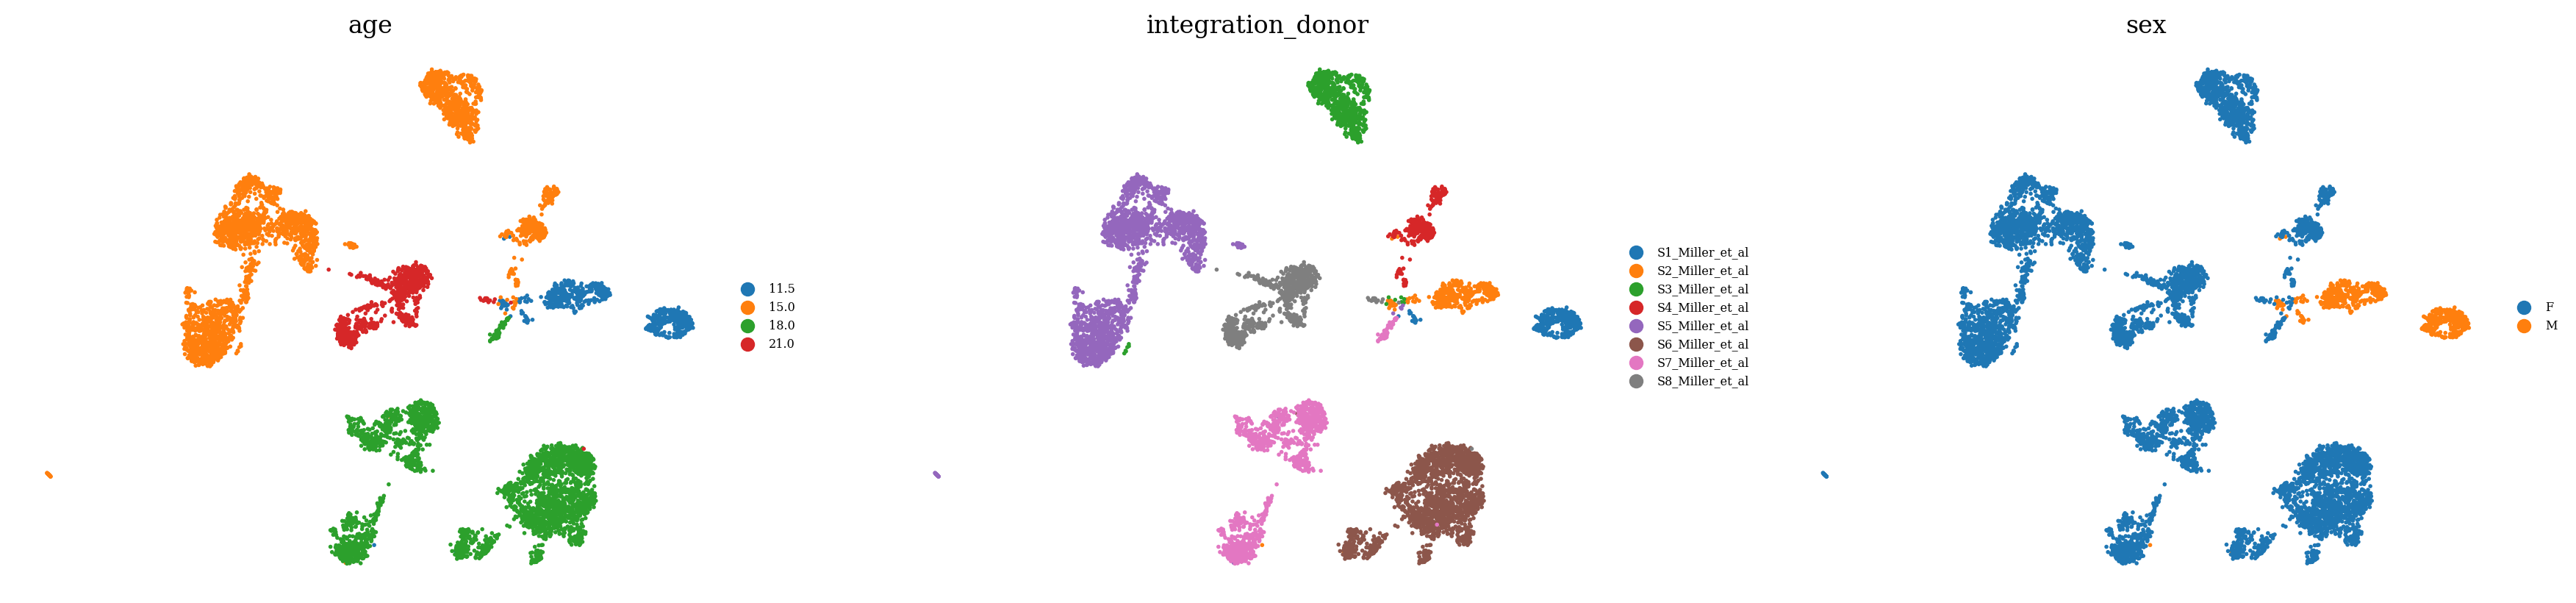

In [19]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

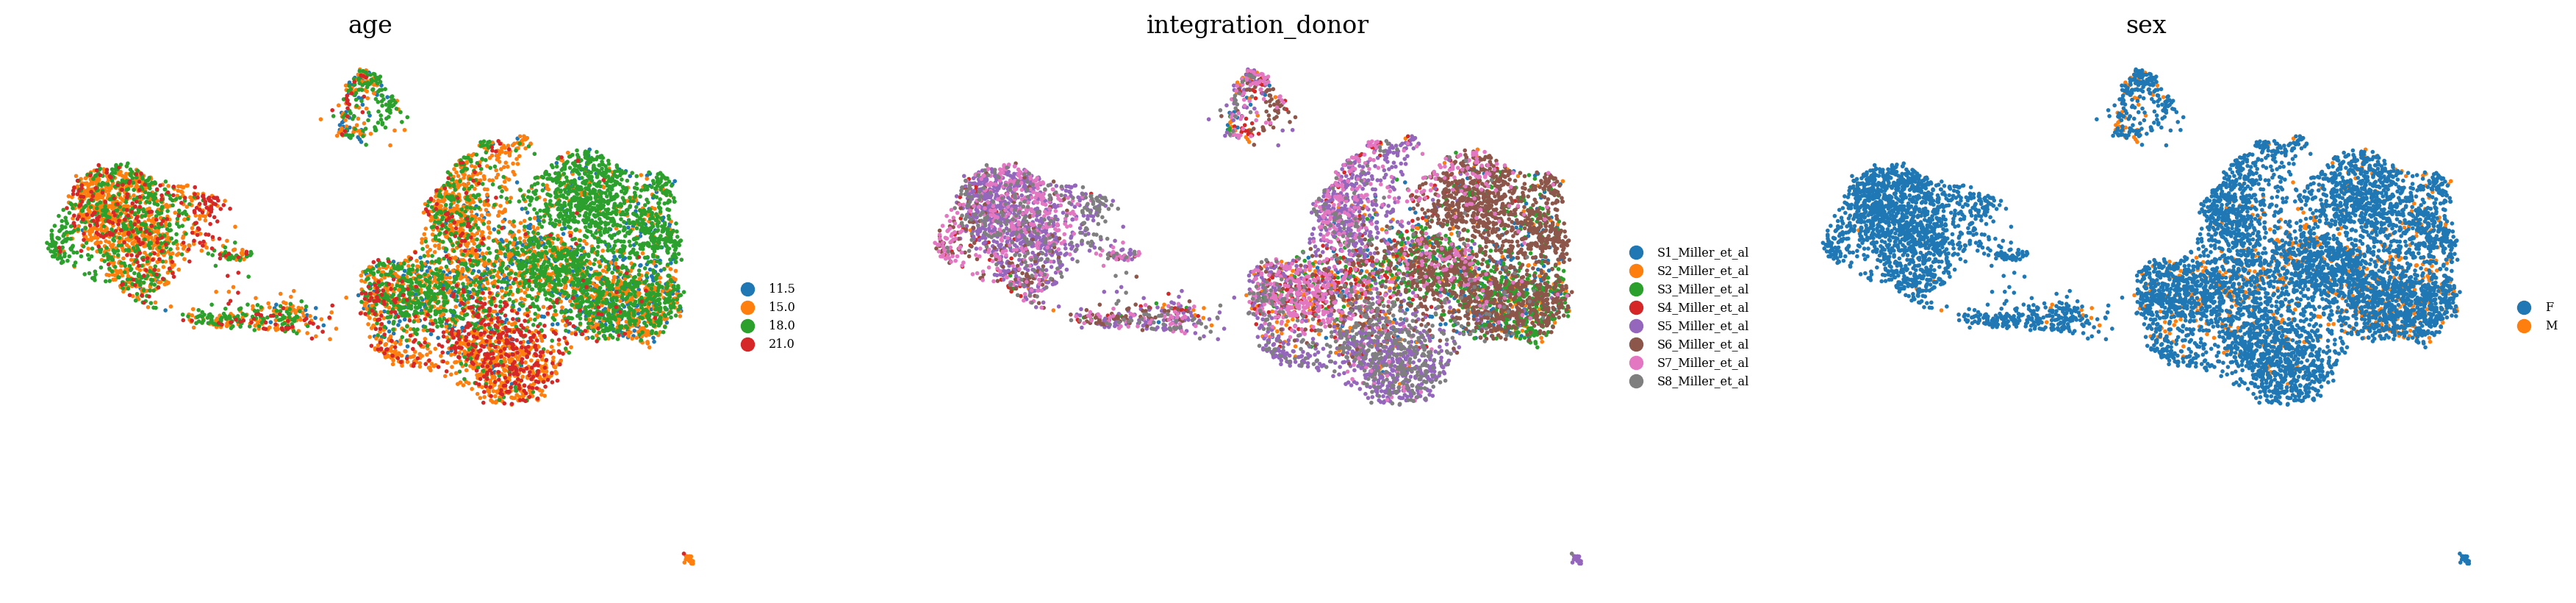

In [20]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=["age", "integration_donor", "sex"], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [21]:
model.predict()

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 1/232 [00:00<00:50,  4.61it/s]

  8%|▊         | 19/232 [00:00<00:02, 74.14it/s]

 13%|█▎        | 31/232 [00:00<00:02, 88.28it/s]

 18%|█▊        | 42/232 [00:00<00:02, 90.76it/s]

 23%|██▎       | 53/232 [00:00<00:01, 92.29it/s]

 28%|██▊       | 64/232 [00:00<00:01, 93.13it/s]

 32%|███▏      | 74/232 [00:00<00:01, 93.76it/s]

 36%|███▌      | 84/232 [00:00<00:01, 94.19it/s]

 41%|████      | 94/232 [00:01<00:01, 94.29it/s]

 45%|████▍     | 104/232 [00:01<00:01, 94.57it/s]

 49%|████▉     | 114/232 [00:01<00:01, 94.75it/s]

 53%|█████▎    | 124/232 [00:01<00:01, 95.04it/s]

 58%|█████▊    | 134/232 [00:01<00:01, 95.31it/s]

 62%|██████▏   | 144/232 [00:01<00:00, 95.53it/s]

 66%|██████▋   | 154/232 [00:01<00:00, 95.66it/s]

 71%|███████   | 164/232 [00:01<00:00, 95.79it/s]

 75%|███████▌  | 174/232 [00:01<00:00, 95.85it/s]

 79%|███████▉  | 184/232 [00:02<00:00, 95.81it/s]

 84%|████████▎ | 194/232 [00:02<00:00, 95.01it/s]

 88%|████████▊ | 204/232 [00:02<00:00, 95.01it/s]

 92%|█████████▏| 214/232 [00:02<00:00, 95.14it/s]

 97%|█████████▋| 224/232 [00:02<00:00, 94.85it/s]

100%|██████████| 232/232 [00:02<00:00, 91.63it/s]

In [22]:
pred_adata = adata[model.test_indices]
true = pred_adata.X.A
pred = pred_adata.obsm["CPA_pred"]

In [23]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind
np.mean(r2s)

0.7751456665819427

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"miller_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)